## Часть 2.
### Обработка данных и анализ моделей

**Оглавление**
* Разделы:
    * [0. Построение базовой модели](#bload)
    * [1. Эксперименты](#exp) 
    * [1_1. Замена выбросов на значения квантилей и замена пропусков в числовых признаках на -1](#exp1)
    * [1_2. Замена пропусков на -1, замена выбросов на квантили, дамми-кодирование](#exp2)
    * [1_3. Замена на медиану и другие статистики](#exp3)
    * [1_4. Раздельное обучение на выборке с пропусками и без в объединенной таблице (train и client_profile)](#exp4)
    * [1_5. Автоматизированное заполнение пропусков](#exp5)
    * [1_6. Сэмплирование классов](#exp6)
    * [2. Вывод](#end)
 

In [1]:
from typing import List, Optional
from tqdm import tqdm

import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt

import seaborn as sns
import scipy.stats as st
from scipy.stats import probplot, ks_2samp

from sklearn.model_selection import KFold, cross_val_score
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.utils.validation import check_is_fitted
import missingno as msno


# plt.style.use('fivethirtyeight')
# %config InlineBackend.figure_format = 'svg'
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

from sklearn.metrics import (roc_auc_score, roc_curve, auc, confusion_matrix, accuracy_score, \
                            classification_report, plot_confusion_matrix, plot_precision_recall_curve, \
                            precision_recall_curve, recall_score, plot_roc_curve)

import xgboost as xgb
import catboost as cb
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
import lightgbm as lgb

from sklearn.model_selection import train_test_split

In [2]:
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    for col in df.columns:
        col_type = df[col].dtype
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')
    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(
        100 * (start_mem - end_mem) / start_mem))

    return df

In [3]:
train = reduce_mem_usage(pd.read_csv(r"./competitive-data-analysis_coursework/train.csv"))
test = reduce_mem_usage(pd.read_csv(r"./competitive-data-analysis_coursework/test.csv"))
client_profile = reduce_mem_usage(pd.read_csv(r"./competitive-data-analysis_coursework/client_profile.csv"))

Memory usage of dataframe is 2.52 MB
Memory usage after optimization is: 0.63 MB
Decreased by 75.0%
Memory usage of dataframe is 2.52 MB
Memory usage after optimization is: 0.79 MB
Decreased by 68.7%
Memory usage of dataframe is 45.78 MB
Memory usage after optimization is: 18.12 MB
Decreased by 60.4%


#### Построение базовой модели<a class='anchor' id='bload'> 

In [74]:
# Трейн -     X_train
# Валидация - X_valid
# Тест -      X_test

In [4]:
cp_columns = [
 'APPLICATION_NUMBER',
 'GENDER',
#  'CHILDRENS',
 'TOTAL_SALARY',
 'AMOUNT_CREDIT',
 'AMOUNT_ANNUITY',
 'EDUCATION_LEVEL',
#  'FAMILY_STATUS',
 'REGION_POPULATION',
 'AGE',
 'DAYS_ON_LAST_JOB',
 'OWN_CAR_AGE',
#  'FLAG_PHONE',
#  'FLAG_EMAIL',
#  'FAMILY_SIZE',
 'EXTERNAL_SCORING_RATING_1',
 'EXTERNAL_SCORING_RATING_2',
 'EXTERNAL_SCORING_RATING_3',
#  'AMT_REQ_CREDIT_BUREAU_HOUR',
#  'AMT_REQ_CREDIT_BUREAU_DAY',
#  'AMT_REQ_CREDIT_BUREAU_WEEK',
#  'AMT_REQ_CREDIT_BUREAU_MON',
#  'AMT_REQ_CREDIT_BUREAU_QRT',
#  'AMT_REQ_CREDIT_BUREAU_YEAR'
]

In [5]:
my_train = pd.merge(train, client_profile[cp_columns], on='APPLICATION_NUMBER', how='left')
my_test = pd.merge(test, client_profile[cp_columns], on='APPLICATION_NUMBER', how='left')

In [6]:
my_train

,APPLICATION_NUMBER,TARGET,NAME_CONTRACT_TYPE,GENDER,TOTAL_SALARY,AMOUNT_CREDIT,AMOUNT_ANNUITY,EDUCATION_LEVEL,REGION_POPULATION,AGE,DAYS_ON_LAST_JOB,OWN_CAR_AGE,EXTERNAL_SCORING_RATING_1,EXTERNAL_SCORING_RATING_2,EXTERNAL_SCORING_RATING_3
0,123687442,0,Cash,M,157500.0,855000.0,25128.0,Secondary / secondary special,0.019101,15728.0,1719.0,11.0,0.700784,0.645914,0.716570
1,123597908,1,Cash,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,123526683,0,Cash,F,135000.0,1006920.0,42660.0,Higher education,0.026392,21557.0,3618.0,NaN,NaN,0.682149,0.267869
3,123710391,1,Cash,M,180000.0,518562.0,22972.5,Secondary / secondary special,0.031329,22338.0,365243.0,NaN,NaN,0.171299,0.170446
4,123590329,1,Cash,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
110088,123458312,0,Cash,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
110089,123672463,0,Cash,F,175500.0,269550.0,12618.0,Secondary / secondary special,0.010032,10519.0,1354.0,NaN,0.528096,0.471774,0.581484
110090,123723001,0,Cash,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
110091,123554358,0,Cash,F,270000.0,1024740.0,49428.0,Incomplete higher,0.019101,15008.0,361.0,22.0,0.653826,0.651227,0.558507


In [8]:
my_train_lgbm = my_train.copy()
# преобразуем все в категории для lgbm
for feature in my_train_lgbm.select_dtypes(include=[np.object]).columns.tolist():
    my_train_lgbm[feature] = pd.Series(my_train_lgbm[feature], dtype="category")

In [9]:
params_lgbm = {
    "boosting_type": "gbdt",
    "objective": "binary",
    "metric": "auc",
    "learning_rate": 0.1,
    "n_estimators": 1500,
    "n_jobs": 6,
    "seed": 99
}

In [10]:
X1 = my_train_lgbm.drop(['TARGET'], axis=1)
y1 = my_train_lgbm['TARGET']

X_train1, X_part1, y_train1, y_part1 = train_test_split(X1, y1, train_size=0.6, random_state=99, stratify=y1)

X_valid1, X_test1, y_valid1, y_test1 = train_test_split(X_part1, y_part1, train_size=0.5, random_state=99, stratify=y_part1)

In [11]:
X_train1.shape, X_valid1.shape, X_test1.shape

((66055, 14), (22019, 14), (22019, 14))

In [12]:
(y_train1==1).sum(), (y_valid1==1).sum(), (y_test1==1).sum()

(5338, 1779, 1780)

In [13]:
model_lgbm = LGBMClassifier(**params_lgbm)
model_lgbm.fit(
    categorical_feature=my_train_lgbm.select_dtypes(include=[np.object]).columns.tolist(),
    X=X_train1,
    y=y_train1,
    eval_set=[(X_train1, y_train1), (X_valid1, y_valid1)],
    early_stopping_rounds=25,
    eval_metric="auc",
    verbose=25
)

Training until validation scores don't improve for 25 rounds
[25]	training's auc: 0.756279	valid_1's auc: 0.714292
[50]	training's auc: 0.787737	valid_1's auc: 0.714534
Early stopping, best iteration is:
[37]	training's auc: 0.773385	valid_1's auc: 0.715226


LGBMClassifier(metric='auc', n_estimators=1500, n_jobs=6, objective='binary',
               seed=99)

In [14]:
# посмотрим на 3-й выборке
roc_auc_score(y_test1, model_lgbm.predict_proba(X_test1)[:,1])

0.7087053114162167

In [15]:
# Далее катбуст -------------------------------------------------------------------------------------------------

In [7]:
my_train_ctb = my_train.copy()

for ii in my_train_ctb.select_dtypes(include=['object', 'category']).columns.tolist():
    my_train_ctb[ii] = my_train_ctb[ii].astype(str)

cat_features_idx = np.where(my_train_ctb.drop('TARGET', axis=1).dtypes == 'object')[0].tolist()
cat_features_idx

[1, 2, 6]

In [8]:
# заполним пропуски
for ii in my_train_ctb.drop('TARGET', axis=1).select_dtypes(exclude=['object', 'category']).columns.tolist():
    my_train_ctb[ii] = my_train_ctb[ii].fillna(-1)

In [9]:
X2 = my_train_ctb.drop(['TARGET'], axis=1)
y2 = my_train_ctb['TARGET']

X_train2, X_part2, y_train2, y_part2 = train_test_split(X2, y2, train_size=0.6, random_state=99, stratify=y2)

X_valid2, X_test2, y_valid2, y_test2 = train_test_split(X_part2, y_part2, train_size=0.5, random_state=99, stratify=y_part2)

In [10]:
X_train2.shape, X_valid2.shape, X_test2.shape

((66055, 14), (22019, 14), (22019, 14))

In [11]:
(y_train2==1).sum(), (y_valid2==1).sum(), (y_test2==1).sum()

(5338, 1779, 1780)

In [129]:
params_ctb = {
    "n_estimators": 1500,
    "loss_function": "Logloss",
    "eval_metric": "AUC",
    "task_type": "CPU",
    "max_bin": 20,
    "verbose": 50,
    "max_depth": 3,
    "l2_leaf_reg": 100,
    "early_stopping_rounds": 25,
    "thread_count": 6,
    "random_seed": 99
}

In [13]:
model_ctb = CatBoostClassifier(**params_ctb)
model_ctb.fit(X_train2, y_train2, eval_set=[(X_train2, y_train2), (X_valid2, y_valid2)], cat_features=cat_features_idx)

0:	test: 0.5889433	test1: 0.5841229	best: 0.5841229 (0)	total: 108ms	remaining: 2m 41s
25:	test: 0.6886063	test1: 0.6846748	best: 0.6846748 (25)	total: 1.26s	remaining: 1m 11s
50:	test: 0.6991848	test1: 0.6928711	best: 0.6935719 (48)	total: 2.34s	remaining: 1m 6s
75:	test: 0.7061310	test1: 0.6990549	best: 0.6993309 (73)	total: 3.41s	remaining: 1m 3s
100:	test: 0.7085376	test1: 0.7013826	best: 0.7013826 (100)	total: 4.47s	remaining: 1m 1s
125:	test: 0.7116964	test1: 0.7052733	best: 0.7052733 (125)	total: 5.5s	remaining: 1m
150:	test: 0.7133187	test1: 0.7063781	best: 0.7063920 (147)	total: 6.55s	remaining: 58.5s
175:	test: 0.7152399	test1: 0.7081050	best: 0.7081084 (172)	total: 7.59s	remaining: 57.1s
200:	test: 0.7169398	test1: 0.7090309	best: 0.7090309 (200)	total: 8.68s	remaining: 56.1s
225:	test: 0.7182682	test1: 0.7109112	best: 0.7109112 (225)	total: 9.7s	remaining: 54.7s
250:	test: 0.7197953	test1: 0.7115608	best: 0.7116039 (248)	total: 10.8s	remaining: 53.7s
275:	test: 0.7207023	te

In [73]:
# посмотрим на 3-й выборке
roc_auc_score(y_test2, model_ctb.predict_proba(X_test2)[:,1])

0.7122433548311164

In [ ]:
# Сразу посмотрим на кросс-валидацию

In [68]:
def make_cross_validation(X: pd.DataFrame,
                          y: pd.Series,
                          estimator: object,
                          metric: callable,
                          cv_strategy):
  
    estimators, fold_train_scores, fold_valid_scores = [], [], []
    oof_predictions = np.zeros(X.shape[0])

    for fold_number, (train_idx, valid_idx) in enumerate(cv_strategy.split(X, y)):
        x_train, x_valid = X.loc[train_idx], X.loc[valid_idx]
        y_train, y_valid = y.loc[train_idx], y.loc[valid_idx]

        estimator.fit(x_train, y_train)
        y_train_pred = estimator.predict_proba(x_train)
        y_valid_pred = estimator.predict_proba(x_valid)

        fold_train_scores.append(metric(y_train, y_train_pred[:,1]))
        fold_valid_scores.append(metric(y_valid, y_valid_pred[:,1]))
        oof_predictions[valid_idx] = y_valid_pred[:,1]

        msg = (
            f"Fold: {fold_number+1}, train-observations = {len(train_idx)}, "
            f"valid-observations = {len(valid_idx)}\n"
            f"train-score = {round(fold_train_scores[fold_number], 4)}, "
            f"valid-score = {round(fold_valid_scores[fold_number], 4)}" 
        )
        print(msg)
        print("="*69)
        estimators.append(estimator)

    oof_score = metric(y, oof_predictions)
    print(f"CV-results train: {round(np.mean(fold_train_scores), 4)} +/- {round(np.std(fold_train_scores), 3)}")
    print(f"CV-results valid: {round(np.mean(fold_valid_scores), 4)} +/- {round(np.std(fold_valid_scores), 3)}")
    print(f"OOF-score = {round(oof_score, 4)}")
    
    print(estimators, oof_score, fold_train_scores, fold_valid_scores, oof_predictions)
    return estimators, oof_score, fold_train_scores, fold_valid_scores, oof_predictions

In [69]:
cv_strategy = KFold(n_splits=5)

estimators, oof_score, fold_train_scores, fold_valid_scores, oof_predictions = make_cross_validation(
    my_train_lgbm.drop('TARGET', axis=1), my_train_lgbm['TARGET'], model_lgbm, metric=roc_auc_score, cv_strategy=cv_strategy
)

Fold: 1, train-observations = 88074, valid-observations = 22019
train-score = 0.9709, valid-score = 0.6851
Fold: 2, train-observations = 88074, valid-observations = 22019
train-score = 0.9717, valid-score = 0.6823
Fold: 3, train-observations = 88074, valid-observations = 22019
train-score = 0.9715, valid-score = 0.6929
Fold: 4, train-observations = 88075, valid-observations = 22018
train-score = 0.9719, valid-score = 0.6862
Fold: 5, train-observations = 88075, valid-observations = 22018
train-score = 0.9712, valid-score = 0.6864
CV-results train: 0.9714 +/- 0.0
CV-results valid: 0.6866 +/- 0.003
OOF-score = 0.6863
[LGBMClassifier(metric='auc', n_estimators=1500, n_jobs=6, objective='binary',
               seed=99), LGBMClassifier(metric='auc', n_estimators=1500, n_jobs=6, objective='binary',
               seed=99), LGBMClassifier(metric='auc', n_estimators=1500, n_jobs=6, objective='binary',
               seed=99), LGBMClassifier(metric='auc', n_estimators=1500, n_jobs=6, objective=

In [75]:
hash_space = 0.1
for item_column in my_train_ctb.drop('TARGET', axis=1).select_dtypes(include=['object', 'category']).columns.tolist():
    for itm in my_train_ctb[item_column].value_counts().index.tolist():
        my_train_ctb.loc[my_train_ctb[item_column] == itm, item_column] = (hash(itm) % hash_space)

    my_train_ctb[item_column] = my_train_ctb[item_column].astype('float')

In [77]:
cv_strategy = KFold(n_splits=5)


estimators, oof_score, fold_train_scores, fold_valid_scores, oof_predictions = make_cross_validation(
    my_train_ctb.drop('TARGET', axis=1), my_train_ctb['TARGET'], model_ctb, metric=roc_auc_score, cv_strategy=cv_strategy
)

0:	total: 14.4ms	remaining: 21.6s
25:	total: 383ms	remaining: 21.7s
50:	total: 730ms	remaining: 20.7s
75:	total: 1.1s	remaining: 20.6s
100:	total: 1.44s	remaining: 20s
125:	total: 1.82s	remaining: 19.8s
150:	total: 2.19s	remaining: 19.6s
175:	total: 2.5s	remaining: 18.8s
200:	total: 2.83s	remaining: 18.3s
225:	total: 3.15s	remaining: 17.8s
250:	total: 3.48s	remaining: 17.3s
275:	total: 3.81s	remaining: 16.9s
300:	total: 4.13s	remaining: 16.5s
325:	total: 4.46s	remaining: 16.1s
350:	total: 4.79s	remaining: 15.7s
375:	total: 5.11s	remaining: 15.3s
400:	total: 5.45s	remaining: 14.9s
425:	total: 5.8s	remaining: 14.6s
450:	total: 6.16s	remaining: 14.3s
475:	total: 6.54s	remaining: 14.1s
500:	total: 6.89s	remaining: 13.7s
525:	total: 7.26s	remaining: 13.4s
550:	total: 7.63s	remaining: 13.1s
575:	total: 7.99s	remaining: 12.8s
600:	total: 8.34s	remaining: 12.5s
625:	total: 8.69s	remaining: 12.1s
650:	total: 9.04s	remaining: 11.8s
675:	total: 9.42s	remaining: 11.5s
700:	total: 9.78s	remaining: 

925:	total: 12.2s	remaining: 7.57s
950:	total: 12.5s	remaining: 7.24s
975:	total: 12.9s	remaining: 6.91s
1000:	total: 13.2s	remaining: 6.57s
1025:	total: 13.5s	remaining: 6.24s
1050:	total: 13.8s	remaining: 5.91s
1075:	total: 14.2s	remaining: 5.58s
1100:	total: 14.5s	remaining: 5.25s
1125:	total: 14.8s	remaining: 4.91s
1150:	total: 15.1s	remaining: 4.58s
1175:	total: 15.4s	remaining: 4.25s
1200:	total: 15.8s	remaining: 3.92s
1225:	total: 16.1s	remaining: 3.6s
1250:	total: 16.4s	remaining: 3.27s
1275:	total: 16.8s	remaining: 2.94s
1300:	total: 17.1s	remaining: 2.61s
1325:	total: 17.4s	remaining: 2.28s
1350:	total: 17.7s	remaining: 1.95s
1375:	total: 18s	remaining: 1.62s
1400:	total: 18.3s	remaining: 1.3s
1425:	total: 18.7s	remaining: 969ms
1450:	total: 19s	remaining: 641ms
1475:	total: 19.3s	remaining: 314ms
1499:	total: 19.6s	remaining: 0us
Fold: 4, train-observations = 88075, valid-observations = 22018
train-score = 0.7385, valid-score = 0.7178
0:	total: 14.7ms	remaining: 22.1s
25:	to

In [ ]:
# Проверим на лидерборде kaggle

In [79]:
my_test_lgbm = my_test.copy()
# преобразуем все в категории для lgbm
for feature in my_test_lgbm.select_dtypes(include=[np.object]).columns.tolist():
    my_test_lgbm[feature] = pd.Series(my_test_lgbm[feature], dtype="category")

In [82]:
sample_submit = pd.read_csv(r"./competitive-data-analysis_coursework/sample_submit.csv")

sample_submit['TARGET'] = model_lgbm.predict_proba(my_test_lgbm)[:,1].tolist()

sample_submit.to_csv(r"./competitive-data-analysis_coursework/submitions/sport_kag_lite26.csv", index=False)
sample_submit

,APPLICATION_NUMBER,TARGET
0,123724268,0.018763
1,123456549,0.273751
2,123428178,0.040506
3,123619984,0.059617
4,123671104,0.007488
...,...,...
165136,123487967,0.086716
165137,123536402,0.031564
165138,123718238,0.078753
165139,123631557,0.000566


In [ ]:
""" на лидерборде kaggle 0.68368 """

In [84]:
my_test_ctb = my_test.copy()
# преобразуем все в str для ctb
for ii in my_test_ctb.select_dtypes(include=['object', 'category']).columns.tolist():
    my_test_ctb[ii] = my_test_ctb[ii].astype(str)

In [86]:
# заполним пропуски
for ii in my_test_ctb.select_dtypes(exclude=['object', 'category']).columns.tolist():
    my_test_ctb[ii] = my_test_ctb[ii].fillna(-1)

In [88]:
hash_space = 0.1
for item_column in my_test_ctb.select_dtypes(include=['object', 'category']).columns.tolist():
    for itm in my_test_ctb[item_column].value_counts().index.tolist():
        my_test_ctb.loc[my_test_ctb[item_column] == itm, item_column] = (hash(itm) % hash_space)

    my_test_ctb[item_column] = my_test_ctb[item_column].astype('float')

In [90]:
sample_submit['TARGET'] = model_ctb.predict_proba(my_test_ctb)[:,1].tolist()

sample_submit.to_csv(r"./competitive-data-analysis_coursework/submitions/sport_kag_lite27.csv", index=False)
sample_submit

,APPLICATION_NUMBER,TARGET
0,123724268,0.082205
1,123456549,0.241916
2,123428178,0.161864
3,123619984,0.084355
4,123671104,0.028426
...,...,...
165136,123487967,0.085340
165137,123536402,0.043519
165138,123718238,0.088342
165139,123631557,0.023415


In [ ]:
""" на лидерборде kaggle 0.72003 """

### 1. Эксперименты <a class='anchor' id='exp'>

#### Эксперимент 1: замена выбросов на значения квантилей и замена пропусков в числовых признаках на -1 <a class='anchor' id='exp1'>

In [38]:
my_train.describe()

,APPLICATION_NUMBER,TARGET,TOTAL_SALARY,AMOUNT_CREDIT,AMOUNT_ANNUITY,REGION_POPULATION,AGE,DAYS_ON_LAST_JOB,OWN_CAR_AGE,EXTERNAL_SCORING_RATING_1,EXTERNAL_SCORING_RATING_2,EXTERNAL_SCORING_RATING_3
count,1.100930e+05,110093.000000,8.953900e+04,8.953900e+04,89534.000000,89539.000000,89539.000000,89539.000000,30533.000000,39091.000000,89345.000000,71808.000000
mean,1.235772e+08,0.080813,1.683996e+05,5.997924e+05,27119.304688,0.020842,16029.821162,67260.609198,12.096224,0.501401,0.513888,0.511014
std,8.880939e+04,0.272550,9.964109e+04,4.031786e+05,14502.823242,0.013796,4355.461281,139057.158252,11.932726,0.209928,0.191252,0.195152
min,1.234233e+08,0.000000,2.565000e+04,4.500000e+04,1615.500000,0.000533,7679.000000,2.000000,0.000000,0.014691,0.000010,0.000527
25%,1.235005e+08,0.000000,1.125000e+05,2.700000e+05,16524.000000,0.010006,12433.000000,927.000000,5.000000,0.334582,0.391285,0.370650
50%,1.235769e+08,0.000000,1.485000e+05,5.177880e+05,24903.000000,0.018850,15728.000000,2206.000000,9.000000,0.504836,0.565177,0.535276
75%,1.236539e+08,0.000000,2.025000e+05,8.086500e+05,34596.000000,0.028663,19668.000000,5660.500000,15.000000,0.671532,0.663661,0.669057
max,1.237308e+08,1.000000,4.500000e+06,4.050000e+06,225000.000000,0.072508,25196.000000,365243.000000,65.000000,0.951624,0.855000,0.896010


In [43]:
# Замена выбросов
my_train.AMOUNT_ANNUITY.quantile(0.99)

70414.516

In [60]:
my_train.DAYS_ON_LAST_JOB.quantile(0.821)

15715.221999999587

In [82]:
my_train_exp1 = my_train.copy()

In [83]:
# Замена выбросов на определенное значение квантиля (почти винзоризация)
my_train_exp1.loc[my_train_exp1['AMOUNT_ANNUITY'] > my_train.AMOUNT_ANNUITY.quantile(0.99), 'AMOUNT_ANNUITY'] = my_train.AMOUNT_ANNUITY.quantile(0.99)

In [84]:
my_train_exp1.loc[my_train_exp1['DAYS_ON_LAST_JOB'] > my_train.AMOUNT_ANNUITY.quantile(0.821), 'DAYS_ON_LAST_JOB'] = my_train.DAYS_ON_LAST_JOB.quantile(0.821)

In [85]:
my_train_exp1.head()

,APPLICATION_NUMBER,TARGET,NAME_CONTRACT_TYPE,GENDER,TOTAL_SALARY,AMOUNT_CREDIT,AMOUNT_ANNUITY,EDUCATION_LEVEL,REGION_POPULATION,AGE,DAYS_ON_LAST_JOB,OWN_CAR_AGE,EXTERNAL_SCORING_RATING_1,EXTERNAL_SCORING_RATING_2,EXTERNAL_SCORING_RATING_3
0,123687442,0,Cash,M,157500.0,855000.0,25128.0,Secondary / secondary special,0.019101,15728.0,1719.000,11.0,0.700784,0.645914,0.716570
1,123597908,1,Cash,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,123526683,0,Cash,F,135000.0,1006920.0,42660.0,Higher education,0.026392,21557.0,3618.000,NaN,NaN,0.682149,0.267869
3,123710391,1,Cash,M,180000.0,518562.0,22972.5,Secondary / secondary special,0.031329,22338.0,15715.222,NaN,NaN,0.171299,0.170446
4,123590329,1,Cash,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [128]:
def get_transform_train_n_split(train):
    for ii in train.select_dtypes(include=['object', 'category']).columns.tolist():
        train[ii] = train[ii].astype(str)

    cat_features_idx = np.where(train.drop('TARGET', axis=1).dtypes == 'object')[0].tolist()

    # заполним пропуски
    for ii in train.drop('TARGET', axis=1).select_dtypes(exclude=['object', 'category']).columns.tolist():
        train[ii] = train[ii].fillna(-1)

    X = train.drop(['TARGET'], axis=1)
    y = train['TARGET']
    X_train, X_part, y_train, y_part = train_test_split(X, y, train_size=0.6, random_state=99, stratify=y)
    X_valid, X_test, y_valid, y_test = train_test_split(X_part, y_part, train_size=0.5, random_state=99, stratify=y_part)
    
    return X_train, y_train, X_valid, y_valid, X_test, y_test, cat_features_idx

In [87]:
X_train_exp1, y_train_exp1, X_valid_exp1, y_valid_exp1, X_test_exp1, y_test_exp1, cat_features_idx_exp1 = get_transform_train_n_split(my_train_exp1)

In [88]:
model_ctb_exp1 = CatBoostClassifier(**params_ctb)
model_ctb_exp1.fit(X_train_exp1, y_train_exp1, eval_set=[(X_train_exp1, y_train_exp1), (X_valid_exp1, y_valid_exp1)], cat_features=cat_features_idx_exp1)

0:	test: 0.5889433	test1: 0.5841229	best: 0.5841229 (0)	total: 45.9ms	remaining: 1m 8s
25:	test: 0.6886063	test1: 0.6846748	best: 0.6846748 (25)	total: 1.21s	remaining: 1m 8s
50:	test: 0.6991848	test1: 0.6928711	best: 0.6935719 (48)	total: 2.37s	remaining: 1m 7s
75:	test: 0.7061310	test1: 0.6990549	best: 0.6993309 (73)	total: 3.53s	remaining: 1m 6s
100:	test: 0.7085376	test1: 0.7013826	best: 0.7013826 (100)	total: 4.62s	remaining: 1m 3s
125:	test: 0.7116964	test1: 0.7052733	best: 0.7052733 (125)	total: 5.71s	remaining: 1m 2s
150:	test: 0.7133187	test1: 0.7063781	best: 0.7063920 (147)	total: 6.8s	remaining: 1m
175:	test: 0.7150733	test1: 0.7081267	best: 0.7081267 (175)	total: 7.92s	remaining: 59.6s
200:	test: 0.7167483	test1: 0.7092392	best: 0.7092392 (200)	total: 9.04s	remaining: 58.4s
225:	test: 0.7180688	test1: 0.7101666	best: 0.7101729 (224)	total: 10.1s	remaining: 57s
250:	test: 0.7194537	test1: 0.7114175	best: 0.7114187 (249)	total: 11.2s	remaining: 55.7s
275:	test: 0.7205596	test

In [89]:
# посмотрим на 3-й выборке(ориентир 0.71224)
roc_auc_score(y_test_exp1, model_ctb_exp1.predict_proba(X_test_exp1)[:,1])

0.7122859636334566

In [ ]:
# замена пропусков на -1 и выбросов на значения квантилей не улучшило модель на валидации и тесте.

#### Эксперимент 2: замена пропусков на -1, замена выбросов на квантили, дамми-кодирование <a class='anchor' id='exp2'>

In [90]:
my_train_exp1.head(2)

,APPLICATION_NUMBER,TARGET,NAME_CONTRACT_TYPE,GENDER,TOTAL_SALARY,AMOUNT_CREDIT,AMOUNT_ANNUITY,EDUCATION_LEVEL,REGION_POPULATION,AGE,DAYS_ON_LAST_JOB,OWN_CAR_AGE,EXTERNAL_SCORING_RATING_1,EXTERNAL_SCORING_RATING_2,EXTERNAL_SCORING_RATING_3
0,123687442,0,Cash,M,157500.0,855000.0,25128.0,Secondary / secondary special,0.019101,15728.0,1719.0,11.0,0.700784,0.645914,0.71657
1,123597908,1,Cash,nan,-1.0,-1.0,-1.0,nan,-1.000000,-1.0,-1.0,-1.0,-1.000000,-1.000000,-1.00000


In [91]:
my_train_exp1 = pd.get_dummies(my_train_exp1, columns = ['NAME_CONTRACT_TYPE', 'GENDER', 'EDUCATION_LEVEL'])

In [93]:
my_train_exp1.head(2)

,APPLICATION_NUMBER,TARGET,TOTAL_SALARY,AMOUNT_CREDIT,AMOUNT_ANNUITY,REGION_POPULATION,AGE,DAYS_ON_LAST_JOB,OWN_CAR_AGE,EXTERNAL_SCORING_RATING_1,...,GENDER_F,GENDER_M,GENDER_XNA,GENDER_nan,EDUCATION_LEVEL_Academic degree,EDUCATION_LEVEL_Higher education,EDUCATION_LEVEL_Incomplete higher,EDUCATION_LEVEL_Lower secondary,EDUCATION_LEVEL_Secondary / secondary special,EDUCATION_LEVEL_nan
0,123687442,0,157500.0,855000.0,25128.0,0.019101,15728.0,1719.0,11.0,0.700784,...,0,1,0,0,0,0,0,0,1,0
1,123597908,1,-1.0,-1.0,-1.0,-1.000000,-1.0,-1.0,-1.0,-1.000000,...,0,0,0,1,0,0,0,0,0,1


In [94]:
X_train_exp1, y_train_exp1, X_valid_exp1, y_valid_exp1, X_test_exp1, y_test_exp1, cat_features_idx_exp1 = get_transform_train_n_split(my_train_exp1)

model_ctb_exp1 = CatBoostClassifier(**params_ctb)
model_ctb_exp1.fit(X_train_exp1, y_train_exp1, eval_set=[(X_train_exp1, y_train_exp1), (X_valid_exp1, y_valid_exp1)], cat_features=cat_features_idx_exp1)

roc_auc_score(y_test_exp1, model_ctb_exp1.predict_proba(X_test_exp1)[:,1])

0:	test: 0.6301718	test1: 0.6307595	best: 0.6307595 (0)	total: 13.9ms	remaining: 20.8s
25:	test: 0.6916132	test1: 0.6875229	best: 0.6901074 (19)	total: 377ms	remaining: 21.4s
50:	test: 0.7044045	test1: 0.6962822	best: 0.6962822 (50)	total: 759ms	remaining: 21.6s
75:	test: 0.7082246	test1: 0.7002396	best: 0.7003761 (74)	total: 1.14s	remaining: 21.4s
100:	test: 0.7093650	test1: 0.7007109	best: 0.7012355 (92)	total: 1.56s	remaining: 21.6s
125:	test: 0.7117400	test1: 0.7033485	best: 0.7033485 (125)	total: 1.95s	remaining: 21.2s
150:	test: 0.7139517	test1: 0.7055089	best: 0.7055089 (150)	total: 2.31s	remaining: 20.7s
175:	test: 0.7157735	test1: 0.7071152	best: 0.7071152 (175)	total: 2.67s	remaining: 20.1s
200:	test: 0.7172509	test1: 0.7091066	best: 0.7091888 (199)	total: 3.06s	remaining: 19.8s
225:	test: 0.7190601	test1: 0.7101048	best: 0.7102501 (221)	total: 3.49s	remaining: 19.7s
250:	test: 0.7202525	test1: 0.7107972	best: 0.7107972 (250)	total: 3.91s	remaining: 19.5s
275:	test: 0.7209390

0.7124393692009698

In [ ]:
# Замена дамми переменными не дала прироста качества.

#### Эксперимент 3: замена на медиану и другие статистики <a class='anchor' id='exp3'>

In [147]:
my_train_exp2 = my_train.copy()

In [148]:
for feature in my_train_exp2.select_dtypes(exclude=['object', 'category']).columns.tolist():
#     my_train_exp2[feature].fillna(-9999, inplace=True)
    
#     median = my_train_exp2[feature].median()
#     my_train_exp2[feature].fillna(median, inplace=True)

#     std = my_train_exp2[feature].std()
#     my_train_exp2[feature].fillna(std, inplace=True)
    
    my_train_exp2[feature].fillna(method='ffill', inplace=True)

In [149]:
my_train_exp2.head()

,APPLICATION_NUMBER,TARGET,NAME_CONTRACT_TYPE,GENDER,TOTAL_SALARY,AMOUNT_CREDIT,AMOUNT_ANNUITY,EDUCATION_LEVEL,REGION_POPULATION,AGE,DAYS_ON_LAST_JOB,OWN_CAR_AGE,EXTERNAL_SCORING_RATING_1,EXTERNAL_SCORING_RATING_2,EXTERNAL_SCORING_RATING_3
0,123687442,0,Cash,M,157500.0,855000.0,25128.0,Secondary / secondary special,0.019101,15728.0,1719.0,11.0,0.700784,0.645914,0.716570
1,123597908,1,Cash,NaN,157500.0,855000.0,25128.0,NaN,0.019101,15728.0,1719.0,11.0,0.700784,0.645914,0.716570
2,123526683,0,Cash,F,135000.0,1006920.0,42660.0,Higher education,0.026392,21557.0,3618.0,11.0,0.700784,0.682149,0.267869
3,123710391,1,Cash,M,180000.0,518562.0,22972.5,Secondary / secondary special,0.031329,22338.0,365243.0,11.0,0.700784,0.171299,0.170446
4,123590329,1,Cash,NaN,180000.0,518562.0,22972.5,NaN,0.031329,22338.0,365243.0,11.0,0.700784,0.171299,0.170446


In [150]:
X_train_exp1, y_train_exp1, X_valid_exp1, y_valid_exp1, X_test_exp1, y_test_exp1, cat_features_idx_exp1 = get_transform_train_n_split(my_train_exp2)

model_ctb_exp1 = CatBoostClassifier(**params_ctb)
model_ctb_exp1.fit(X_train_exp1, y_train_exp1, eval_set=[(X_train_exp1, y_train_exp1), (X_valid_exp1, y_valid_exp1)], cat_features=cat_features_idx_exp1)

roc_auc_score(y_test_exp1, model_ctb_exp1.predict_proba(X_test_exp1)[:,1])

0:	test: 0.5854518	test1: 0.5830832	best: 0.5830832 (0)	total: 44.8ms	remaining: 1m 7s
25:	test: 0.6718318	test1: 0.6611131	best: 0.6611131 (25)	total: 1.22s	remaining: 1m 9s
50:	test: 0.6760865	test1: 0.6655752	best: 0.6666427 (35)	total: 2.46s	remaining: 1m 9s
75:	test: 0.6884436	test1: 0.6781355	best: 0.6781355 (75)	total: 3.64s	remaining: 1m 8s
100:	test: 0.6954670	test1: 0.6853742	best: 0.6853742 (100)	total: 4.68s	remaining: 1m 4s
125:	test: 0.6996431	test1: 0.6892389	best: 0.6892389 (125)	total: 5.76s	remaining: 1m 2s
150:	test: 0.7023511	test1: 0.6914407	best: 0.6914407 (150)	total: 6.85s	remaining: 1m 1s
175:	test: 0.7045895	test1: 0.6929432	best: 0.6929432 (175)	total: 7.91s	remaining: 59.5s
200:	test: 0.7062874	test1: 0.6940847	best: 0.6940847 (200)	total: 9.01s	remaining: 58.2s
225:	test: 0.7076243	test1: 0.6952115	best: 0.6952115 (225)	total: 10.2s	remaining: 57.3s
250:	test: 0.7085994	test1: 0.6955457	best: 0.6955457 (250)	total: 11.2s	remaining: 56s
275:	test: 0.7099623	

0.702745353142309

In [ ]:
# Замены на нули,
#        -9999(крайне незначительно улучшает),
#        медиану(не улучшает),
#        std(ухудшает),
#        backfill(ухудшает),
#        bfill(ухудшает),
#        pad(ухудшает),
#        ffill(ухудшает)  

# НЕ УЛУЧШАЮТ КАЧЕСТВО! (при фиксированных гиперпараметрах катбуста)

#### Эксперимент 4: обучение только на существующих в таблицах train и client_profile пользователях <a class='anchor' id='exp4'>

In [212]:
#     (20554 пользователей client_profile нет в train)
my_train_exp3 = my_train.copy()

In [213]:
my_train_exp3_notna_appl = my_train_exp3.loc[my_train_exp3.GENDER.notna()]
my_train_exp3_notna_appl

,APPLICATION_NUMBER,TARGET,NAME_CONTRACT_TYPE,GENDER,TOTAL_SALARY,AMOUNT_CREDIT,AMOUNT_ANNUITY,EDUCATION_LEVEL,REGION_POPULATION,AGE,DAYS_ON_LAST_JOB,OWN_CAR_AGE,EXTERNAL_SCORING_RATING_1,EXTERNAL_SCORING_RATING_2,EXTERNAL_SCORING_RATING_3
0,123687442,0,Cash,M,157500.0,855000.0,25128.0,Secondary / secondary special,0.019101,15728.0,1719.0,11.0,0.700784,0.645914,0.716570
2,123526683,0,Cash,F,135000.0,1006920.0,42660.0,Higher education,0.026392,21557.0,3618.0,NaN,NaN,0.682149,0.267869
3,123710391,1,Cash,M,180000.0,518562.0,22972.5,Secondary / secondary special,0.031329,22338.0,365243.0,NaN,NaN,0.171299,0.170446
5,123718821,0,Cash,F,180000.0,755190.0,36459.0,Secondary / secondary special,0.010032,16049.0,187.0,20.0,NaN,0.548504,0.331251
6,123544624,0,Cash,M,202500.0,1078200.0,38331.0,Secondary / secondary special,0.031329,23087.0,16364.0,NaN,NaN,0.547421,0.740799
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
110082,123595479,0,Cash,F,225000.0,990432.0,32863.5,Secondary / secondary special,0.072508,21257.0,365243.0,NaN,0.768198,0.713399,0.529890
110083,123426326,0,Cash,F,135000.0,995643.0,32904.0,Secondary / secondary special,0.007305,12726.0,3044.0,11.0,0.410920,0.592042,0.570917
110089,123672463,0,Cash,F,175500.0,269550.0,12618.0,Secondary / secondary special,0.010032,10519.0,1354.0,NaN,0.528096,0.471774,0.581484
110091,123554358,0,Cash,F,270000.0,1024740.0,49428.0,Incomplete higher,0.019101,15008.0,361.0,22.0,0.653826,0.651227,0.558507


In [214]:
X_train_exp4, y_train_exp4, X_valid_exp4, y_valid_exp4, X_test_exp4, y_test_exp4, cat_features_idx_exp4 = get_transform_train_n_split(my_train_exp3_notna_appl)

model_ctb_exp4 = CatBoostClassifier(**params_ctb)
model_ctb_exp4.fit(X_train_exp4, y_train_exp4, eval_set=[(X_train_exp4, y_train_exp4), (X_valid_exp4, y_valid_exp4)], cat_features=cat_features_idx_exp4)

roc_auc_score(y_test_exp4, model_ctb_exp4.predict_proba(X_test_exp4)[:,1])

0:	test: 0.6121325	test1: 0.6123316	best: 0.6123316 (0)	total: 41.1ms	remaining: 1m 1s
25:	test: 0.7195445	test1: 0.7240811	best: 0.7240811 (25)	total: 1.13s	remaining: 1m 3s
50:	test: 0.7254485	test1: 0.7286115	best: 0.7286115 (50)	total: 2.17s	remaining: 1m 1s
75:	test: 0.7298872	test1: 0.7331655	best: 0.7332388 (74)	total: 3.16s	remaining: 59.2s
100:	test: 0.7350961	test1: 0.7395665	best: 0.7395665 (100)	total: 4.09s	remaining: 56.6s
125:	test: 0.7377024	test1: 0.7425374	best: 0.7425374 (125)	total: 5.01s	remaining: 54.7s
150:	test: 0.7399190	test1: 0.7444082	best: 0.7444082 (150)	total: 5.95s	remaining: 53.1s
175:	test: 0.7421460	test1: 0.7456698	best: 0.7457015 (173)	total: 7.03s	remaining: 52.9s
200:	test: 0.7438825	test1: 0.7467097	best: 0.7467097 (200)	total: 8.07s	remaining: 52.1s
225:	test: 0.7453074	test1: 0.7479194	best: 0.7479194 (225)	total: 9.1s	remaining: 51.3s
250:	test: 0.7466014	test1: 0.7489582	best: 0.7489582 (250)	total: 10s	remaining: 49.9s
275:	test: 0.7474387	t

0.7336740457746497

In [ ]:
# Качество выросло значительно! Пропуски ухудшают качество модели, а значит работа с пропусками крайне необходима.

In [215]:
my_train_exp3_1 = my_train.copy()

In [216]:
my_train_exp3_na_appl = my_train_exp3_1.loc[my_train_exp3_1.GENDER.isna()]
my_train_exp3_na_appl

,APPLICATION_NUMBER,TARGET,NAME_CONTRACT_TYPE,GENDER,TOTAL_SALARY,AMOUNT_CREDIT,AMOUNT_ANNUITY,EDUCATION_LEVEL,REGION_POPULATION,AGE,DAYS_ON_LAST_JOB,OWN_CAR_AGE,EXTERNAL_SCORING_RATING_1,EXTERNAL_SCORING_RATING_2,EXTERNAL_SCORING_RATING_3
1,123597908,1,Cash,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,123590329,1,Cash,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10,123572161,0,Cash,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
16,123649339,0,Cash,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
17,123646531,1,Cash,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
110085,123447470,0,Cash,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
110086,123477663,0,Credit Card,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
110087,123560225,0,Cash,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
110088,123458312,0,Cash,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [217]:
X_train_exp41, y_train_exp41, X_valid_exp41, y_valid_exp41, X_test_exp41, y_test_exp41, cat_features_idx_exp41 = get_transform_train_n_split(my_train_exp3_na_appl)

model_ctb_exp41 = CatBoostClassifier(**params_ctb)
model_ctb_exp41.fit(X_train_exp41, y_train_exp41, eval_set=[(X_train_exp41, y_train_exp41), (X_valid_exp41, y_valid_exp41)], cat_features=cat_features_idx_exp41)

roc_auc_score(y_test_exp41, model_ctb_exp41.predict_proba(X_test_exp41)[:,1])

0:	test: 0.5213125	test1: 0.5177966	best: 0.5177966 (0)	total: 6.65ms	remaining: 9.97s
25:	test: 0.5376241	test1: 0.5268719	best: 0.5268719 (24)	total: 157ms	remaining: 8.88s
Stopped by overfitting detector  (25 iterations wait)

bestTest = 0.5268718722
bestIteration = 24

Shrink model to first 25 iterations.


0.49395228005903047

In [ ]:
# Невозможно предсказать по остаткам, модель получается на уровне случайного гадания. 

In [177]:
# my_train_exp3_1.drop(['TARGET', 'APPLICATION_NUMBER'], axis=1).columns.tolist()
my_train_exp3_na_appl

,APPLICATION_NUMBER,TARGET,NAME_CONTRACT_TYPE,GENDER,TOTAL_SALARY,AMOUNT_CREDIT,AMOUNT_ANNUITY,EDUCATION_LEVEL,REGION_POPULATION,AGE,DAYS_ON_LAST_JOB,OWN_CAR_AGE,EXTERNAL_SCORING_RATING_1,EXTERNAL_SCORING_RATING_2,EXTERNAL_SCORING_RATING_3
1,123597908,1,Cash,nan,-1.0,-1.0,-1.0,nan,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
4,123590329,1,Cash,nan,-1.0,-1.0,-1.0,nan,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
10,123572161,0,Cash,nan,-1.0,-1.0,-1.0,nan,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
16,123649339,0,Cash,nan,-1.0,-1.0,-1.0,nan,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
17,123646531,1,Cash,nan,-1.0,-1.0,-1.0,nan,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
110085,123447470,0,Cash,nan,-1.0,-1.0,-1.0,nan,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
110086,123477663,0,Credit Card,nan,-1.0,-1.0,-1.0,nan,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
110087,123560225,0,Cash,nan,-1.0,-1.0,-1.0,nan,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
110088,123458312,0,Cash,nan,-1.0,-1.0,-1.0,nan,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0


In [178]:
for ii in my_train_exp3_na_appl.drop(['TARGET', 'APPLICATION_NUMBER'], axis=1).columns.tolist():
    my_train_exp3_na_appl[ii] = my_train_exp3_na_appl[ii].astype(str)

In [180]:
len(model_ctb_exp1.predict_proba(my_train_exp3_na_appl.drop('TARGET', axis=1))[:,1])

20554

In [181]:
my_train_exp3_na_appl['pred_on_na'] = model_ctb_exp1.predict_proba(my_train_exp3_na_appl.drop('TARGET', axis=1))[:,1].tolist()

In [182]:
my_train_exp3_na_appl

,APPLICATION_NUMBER,TARGET,NAME_CONTRACT_TYPE,GENDER,TOTAL_SALARY,AMOUNT_CREDIT,AMOUNT_ANNUITY,EDUCATION_LEVEL,REGION_POPULATION,AGE,DAYS_ON_LAST_JOB,OWN_CAR_AGE,EXTERNAL_SCORING_RATING_1,EXTERNAL_SCORING_RATING_2,EXTERNAL_SCORING_RATING_3,pred_on_na
1,123597908,1,Cash,nan,-1.0,-1.0,-1.0,nan,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0.220483
4,123590329,1,Cash,nan,-1.0,-1.0,-1.0,nan,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0.220805
10,123572161,0,Cash,nan,-1.0,-1.0,-1.0,nan,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0.220255
16,123649339,0,Cash,nan,-1.0,-1.0,-1.0,nan,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0.218966
17,123646531,1,Cash,nan,-1.0,-1.0,-1.0,nan,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0.218966
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
110085,123447470,0,Cash,nan,-1.0,-1.0,-1.0,nan,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0.221253
110086,123477663,0,Credit Card,nan,-1.0,-1.0,-1.0,nan,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0.187120
110087,123560225,0,Cash,nan,-1.0,-1.0,-1.0,nan,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0.220255
110088,123458312,0,Cash,nan,-1.0,-1.0,-1.0,nan,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0.221253


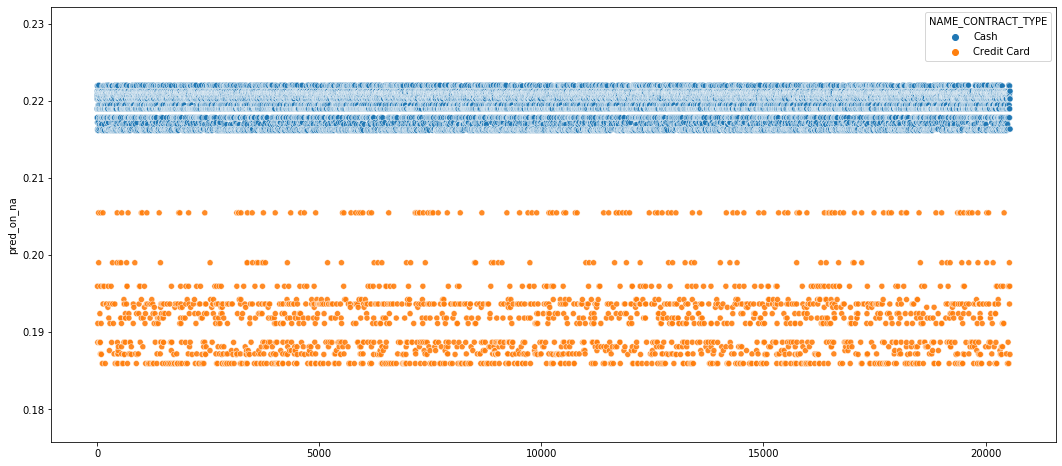

In [189]:
plt.figure(figsize=(18, 8))
sns.scatterplot(range(len(my_train_exp3_na_appl['pred_on_na'].tolist())), my_train_exp3_na_appl['pred_on_na'], alpha=0.9, hue=my_train_exp3_na_appl['NAME_CONTRACT_TYPE'])

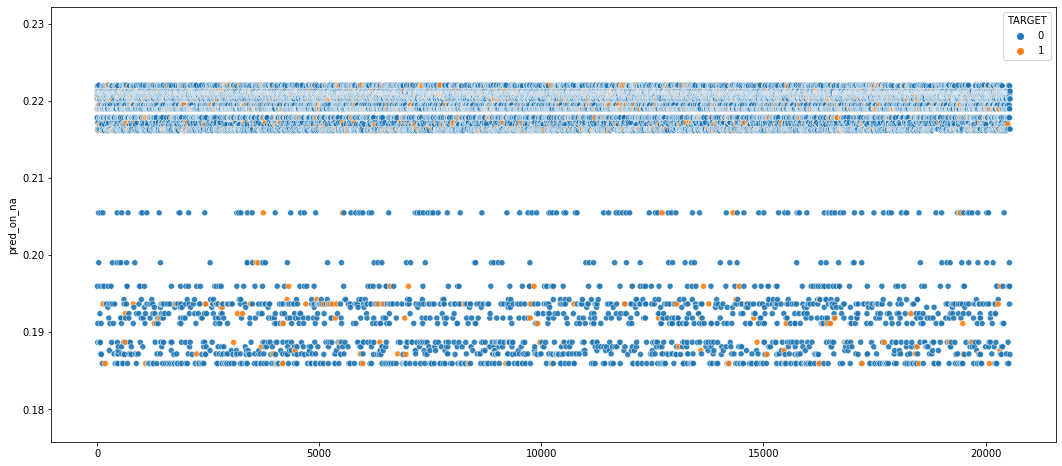

In [190]:
plt.figure(figsize=(18, 8))
sns.scatterplot(range(len(my_train_exp3_na_appl['pred_on_na'].tolist())), my_train_exp3_na_appl['pred_on_na'], alpha=0.9, hue=my_train_exp3_na_appl['TARGET'])

In [194]:
len(my_train_exp3_na_appl.loc[my_train_exp3_na_appl['TARGET'] == 1]) / len(my_train_exp3_na_appl.loc[my_train_exp3_na_appl['TARGET'] == 0])



0.08953087728597933

In [ ]:
# Т.е. всего 8% невозвратов кредита приходится на наблюдения с пропусками!

In [ ]:
# Посмотрим в разрезе NAME_CONTRACT_TYPE

In [201]:
# 1580 / 17004 приходится на Cash
len(my_train_exp3_na_appl.loc[(my_train_exp3_na_appl['TARGET'] == 1) & (my_train_exp3_na_appl['NAME_CONTRACT_TYPE'] == 'Cash')]) / \
len(my_train_exp3_na_appl.loc[(my_train_exp3_na_appl['TARGET'] == 0) & (my_train_exp3_na_appl['NAME_CONTRACT_TYPE'] == 'Cash')])

0.09291931310279934

In [202]:
# 109 / 1861 приходится на Credit Card
len(my_train_exp3_na_appl.loc[(my_train_exp3_na_appl['TARGET'] == 1) & (my_train_exp3_na_appl['NAME_CONTRACT_TYPE'] == 'Credit Card')]) / \
len(my_train_exp3_na_appl.loc[(my_train_exp3_na_appl['TARGET'] == 0) & (my_train_exp3_na_appl['NAME_CONTRACT_TYPE'] == 'Credit Card')])

0.05857066093498119

In [ ]:
"""
ДАЛЕЕ 3 ВАРИАНТА:
1) сделать прогноз на заполненых и проставить все нули вручную для пустых
2) сделать прогноз на заполненых и проставить случайное гадание модели на пустых
3) сделать прогноз на заполненых и сделать прогноз на пропущенных, используя дополнительные датасеты(с платежами и т.д.)
 """

In [ ]:
"""ВАРИАНТЫ 1,2"""

In [221]:
my_test_notna = my_test.loc[my_test['GENDER'].notna()]
my_test_na = my_test.loc[my_test['GENDER'].isna()]

In [222]:
for ii in my_test_notna.select_dtypes(include=['object', 'category']).columns.tolist():
    my_test_notna[ii] = my_test_notna[ii].astype(str)
    my_test_na[ii] = my_test_na[ii].astype(str)

# заполним пропуски
for ii in my_test_notna.select_dtypes(exclude=['object', 'category']).columns.tolist():
    my_test_notna[ii] = my_test_notna[ii].fillna(-1)
    my_test_na[ii] = my_test_na[ii].fillna(-1)

In [223]:
model_ctb_exp4.predict_proba(my_test_notna)[:,1]

array([0.07888517, 0.23618164, 0.15537997, ..., 0.04156189, 0.03109431,
       0.06985404])

In [224]:
my_test_notna['pred_notna'] = model_ctb_exp4.predict_proba(my_test_notna)[:,1].tolist()
my_test_notna

,APPLICATION_NUMBER,NAME_CONTRACT_TYPE,GENDER,TOTAL_SALARY,AMOUNT_CREDIT,AMOUNT_ANNUITY,EDUCATION_LEVEL,REGION_POPULATION,AGE,DAYS_ON_LAST_JOB,OWN_CAR_AGE,EXTERNAL_SCORING_RATING_1,EXTERNAL_SCORING_RATING_2,EXTERNAL_SCORING_RATING_3,pred_notna
0,123724268,Cash,M,117000.0,1125000.0,32895.0,Secondary / secondary special,0.028663,16007.0,2646.0,20.0,-1.000000,0.628266,-1.000000,0.078885
1,123456549,Cash,F,81000.0,312768.0,17095.5,Secondary / secondary special,0.019689,10315.0,459.0,-1.0,-1.000000,0.578161,0.188490,0.236182
2,123428178,Credit Card,F,157500.0,450000.0,22500.0,Secondary / secondary special,0.019101,13016.0,977.0,-1.0,-1.000000,0.152544,0.382502,0.155380
4,123671104,Cash,F,90000.0,254700.0,24939.0,Higher education,0.015221,17743.0,9258.0,-1.0,0.718604,0.505704,0.415347,0.027894
5,123632747,Credit Card,F,315000.0,450000.0,22500.0,Secondary / secondary special,0.072508,21437.0,3714.0,-1.0,-1.000000,0.703016,0.436507,0.020578
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
165130,123642343,Credit Card,F,90000.0,247500.0,12375.0,Secondary / secondary special,0.022625,18982.0,1325.0,-1.0,0.732632,0.735070,0.712155,0.009789
165134,123484380,Cash,F,126000.0,206271.0,21789.0,Higher education,0.010556,15322.0,2276.0,29.0,0.861871,0.590599,0.579727,0.019270
165137,123536402,Cash,M,135000.0,450000.0,16807.5,Secondary / secondary special,0.028663,18610.0,10398.0,23.0,-1.000000,0.665971,0.535276,0.041562
165139,123631557,Cash,F,112500.0,350181.0,36769.5,Secondary / secondary special,0.030755,20551.0,365243.0,-1.0,-1.000000,0.761376,-1.000000,0.031094


In [225]:
my_test_na['pred_na'] = model_ctb_exp41.predict_proba(my_test_na)[:,1].tolist()
my_test_na

,APPLICATION_NUMBER,NAME_CONTRACT_TYPE,GENDER,TOTAL_SALARY,AMOUNT_CREDIT,AMOUNT_ANNUITY,EDUCATION_LEVEL,REGION_POPULATION,AGE,DAYS_ON_LAST_JOB,OWN_CAR_AGE,EXTERNAL_SCORING_RATING_1,EXTERNAL_SCORING_RATING_2,EXTERNAL_SCORING_RATING_3,pred_na
3,123619984,Cash,nan,-1.0,-1.0,-1.0,nan,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0.218966
6,123728867,Credit Card,nan,-1.0,-1.0,-1.0,nan,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0.205479
10,123471321,Cash,nan,-1.0,-1.0,-1.0,nan,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0.221275
15,123519890,Cash,nan,-1.0,-1.0,-1.0,nan,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0.221041
20,123493724,Cash,nan,-1.0,-1.0,-1.0,nan,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0.221041
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
165132,123436663,Cash,nan,-1.0,-1.0,-1.0,nan,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0.219461
165133,123633552,Cash,nan,-1.0,-1.0,-1.0,nan,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0.218966
165135,123596319,Cash,nan,-1.0,-1.0,-1.0,nan,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0.220483
165136,123487967,Cash,nan,-1.0,-1.0,-1.0,nan,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0.222028


In [226]:
test_all_pred = my_test.copy()

In [227]:
test_all_pred = pd.merge(test_all_pred, my_test_notna[['APPLICATION_NUMBER', 'pred_notna']], on='APPLICATION_NUMBER', how='left')

In [229]:
test_all_pred = pd.merge(test_all_pred, my_test_na[['APPLICATION_NUMBER', 'pred_na']], on='APPLICATION_NUMBER', how='left')

In [230]:
test_all_pred

,APPLICATION_NUMBER,NAME_CONTRACT_TYPE,GENDER,TOTAL_SALARY,AMOUNT_CREDIT,AMOUNT_ANNUITY,EDUCATION_LEVEL,REGION_POPULATION,AGE,DAYS_ON_LAST_JOB,OWN_CAR_AGE,EXTERNAL_SCORING_RATING_1,EXTERNAL_SCORING_RATING_2,EXTERNAL_SCORING_RATING_3,pred_notna,pred_na
0,123724268,Cash,M,117000.0,1125000.0,32895.0,Secondary / secondary special,0.028663,16007.0,2646.0,20.0,NaN,0.628266,NaN,0.078885,NaN
1,123456549,Cash,F,81000.0,312768.0,17095.5,Secondary / secondary special,0.019689,10315.0,459.0,NaN,NaN,0.578161,0.188490,0.236182,NaN
2,123428178,Credit Card,F,157500.0,450000.0,22500.0,Secondary / secondary special,0.019101,13016.0,977.0,NaN,NaN,0.152544,0.382502,0.155380,NaN
3,123619984,Cash,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.218966
4,123671104,Cash,F,90000.0,254700.0,24939.0,Higher education,0.015221,17743.0,9258.0,NaN,0.718604,0.505704,0.415347,0.027894,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
165136,123487967,Cash,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.222028
165137,123536402,Cash,M,135000.0,450000.0,16807.5,Secondary / secondary special,0.028663,18610.0,10398.0,23.0,NaN,0.665971,0.535276,0.041562,NaN
165138,123718238,Cash,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.216339
165139,123631557,Cash,F,112500.0,350181.0,36769.5,Secondary / secondary special,0.030755,20551.0,365243.0,NaN,NaN,0.761376,NaN,0.031094,NaN


In [233]:
test_all_pred['pred_notna'].fillna(0, inplace=True)
test_all_pred['pred_na'].fillna(0, inplace=True)

In [234]:
test_all_pred['sum_pred'] = test_all_pred['pred_notna'] + test_all_pred['pred_na']

In [235]:
test_all_pred

,APPLICATION_NUMBER,NAME_CONTRACT_TYPE,GENDER,TOTAL_SALARY,AMOUNT_CREDIT,AMOUNT_ANNUITY,EDUCATION_LEVEL,REGION_POPULATION,AGE,DAYS_ON_LAST_JOB,OWN_CAR_AGE,EXTERNAL_SCORING_RATING_1,EXTERNAL_SCORING_RATING_2,EXTERNAL_SCORING_RATING_3,pred_notna,pred_na,sum_pred
0,123724268,Cash,M,117000.0,1125000.0,32895.0,Secondary / secondary special,0.028663,16007.0,2646.0,20.0,NaN,0.628266,NaN,0.078885,0.000000,0.078885
1,123456549,Cash,F,81000.0,312768.0,17095.5,Secondary / secondary special,0.019689,10315.0,459.0,NaN,NaN,0.578161,0.188490,0.236182,0.000000,0.236182
2,123428178,Credit Card,F,157500.0,450000.0,22500.0,Secondary / secondary special,0.019101,13016.0,977.0,NaN,NaN,0.152544,0.382502,0.155380,0.000000,0.155380
3,123619984,Cash,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.218966,0.218966
4,123671104,Cash,F,90000.0,254700.0,24939.0,Higher education,0.015221,17743.0,9258.0,NaN,0.718604,0.505704,0.415347,0.027894,0.000000,0.027894
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
165136,123487967,Cash,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.222028,0.222028
165137,123536402,Cash,M,135000.0,450000.0,16807.5,Secondary / secondary special,0.028663,18610.0,10398.0,23.0,NaN,0.665971,0.535276,0.041562,0.000000,0.041562
165138,123718238,Cash,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.216339,0.216339
165139,123631557,Cash,F,112500.0,350181.0,36769.5,Secondary / secondary special,0.030755,20551.0,365243.0,NaN,NaN,0.761376,NaN,0.031094,0.000000,0.031094


In [237]:
sample_submit = pd.read_csv(r"./competitive-data-analysis_coursework/sample_submit.csv")

# sample_submit['TARGET'] = test_all_pred['sum_pred'].tolist()
sample_submit['TARGET'] = test_all_pred['pred_notna'].tolist()

sample_submit.to_csv(r"./competitive-data-analysis_coursework/submitions/sport_kag_lite29.csv", index=False)
sample_submit

,APPLICATION_NUMBER,TARGET
0,123724268,0.078885
1,123456549,0.236182
2,123428178,0.155380
3,123619984,0.000000
4,123671104,0.027894
...,...,...
165136,123487967,0.000000
165137,123536402,0.041562
165138,123718238,0.000000
165139,123631557,0.031094


In [ ]:
"""ВАРИАНТ 3"""

In [238]:
payments = reduce_mem_usage(pd.read_csv(r"./competitive-data-analysis_coursework/payments.csv"))
bki = reduce_mem_usage(pd.read_csv(r"./competitive-data-analysis_coursework/bki.csv"))
applications_history = reduce_mem_usage(pd.read_csv(r"./competitive-data-analysis_coursework/applications_history.csv"))

Memory usage of dataframe is 62.50 MB
Memory usage after optimization is: 29.30 MB
Decreased by 53.1%
Memory usage of dataframe is 122.60 MB
Memory usage after optimization is: 48.68 MB
Decreased by 60.3%
Memory usage of dataframe is 331.31 MB
Memory usage after optimization is: 114.69 MB
Decreased by 65.4%


In [250]:
# Посмотрим где пропусков пользователей меньше в сравнении с датасетом тест
my_test_na_appl_num = set(my_test_na['APPLICATION_NUMBER'].values)
my_train_exp3_na_appl_num = set(my_train_exp3_na_appl['APPLICATION_NUMBER'].values)
payments_appl_num = set(payments['APPLICATION_NUMBER'].values)
bki_appl_num = set(bki['APPLICATION_NUMBER'].values)
applications_history_appl_num = set(applications_history['APPLICATION_NUMBER'].values)

In [251]:
len(my_train_exp3_na_appl_num - payments_appl_num), len(my_train_exp3_na_appl_num - bki_appl_num), len(my_train_exp3_na_appl_num - applications_history_appl_num)

(5281, 4769, 1022)

In [252]:
len(my_test_na_appl_num - payments_appl_num), len(my_test_na_appl_num - bki_appl_num), len(my_test_na_appl_num - applications_history_appl_num)

(7913, 7203, 1466)

In [253]:
len(my_train_exp3_na_appl_num - payments_appl_num - bki_appl_num - applications_history_appl_num)

287

In [246]:
len(my_test_na_appl_num - payments_appl_num - bki_appl_num - applications_history_appl_num)

361

In [255]:
my_train_na = pd.merge(my_train_exp3_na_appl, payments, on='APPLICATION_NUMBER', how='left')
my_train_na = pd.merge(my_train_na, bki, on='APPLICATION_NUMBER', how='left')
my_train_na = pd.merge(my_train_na, applications_history, on='APPLICATION_NUMBER', how='left')
my_train_na

,APPLICATION_NUMBER,TARGET,NAME_CONTRACT_TYPE_x,GENDER,TOTAL_SALARY,AMOUNT_CREDIT_x,AMOUNT_ANNUITY_x,EDUCATION_LEVEL,REGION_POPULATION,AGE,...,NAME_PRODUCT_TYPE,SELLERPLACE_AREA,CNT_PAYMENT,NAME_YIELD_GROUP,DAYS_FIRST_DRAWING,DAYS_FIRST_DUE,DAYS_LAST_DUE_1ST_VERSION,DAYS_LAST_DUE,DAYS_TERMINATION,NFLAG_INSURED_ON_APPROVAL
0,123597908,1,Cash,nan,-1.0,-1.0,-1.0,nan,-1.0,-1.0,...,x-sell,-1.0,36.0,high,NaN,NaN,NaN,NaN,NaN,NaN
1,123597908,1,Cash,nan,-1.0,-1.0,-1.0,nan,-1.0,-1.0,...,XNA,12.0,10.0,high,365243.0,690.0,420.0,420.0,413.0,0.0
2,123597908,1,Cash,nan,-1.0,-1.0,-1.0,nan,-1.0,-1.0,...,XNA,145.0,12.0,low_action,365243.0,859.0,529.0,529.0,518.0,0.0
3,123597908,1,Cash,nan,-1.0,-1.0,-1.0,nan,-1.0,-1.0,...,x-sell,-1.0,48.0,high,NaN,NaN,NaN,NaN,NaN,NaN
4,123597908,1,Cash,nan,-1.0,-1.0,-1.0,nan,-1.0,-1.0,...,x-sell,-1.0,36.0,high,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1513232,123723001,0,Cash,nan,-1.0,-1.0,-1.0,nan,-1.0,-1.0,...,XNA,156.0,12.0,middle,365243.0,708.0,378.0,558.0,526.0,0.0
1513233,123723001,0,Cash,nan,-1.0,-1.0,-1.0,nan,-1.0,-1.0,...,XNA,156.0,6.0,low_normal,365243.0,160.0,10.0,40.0,34.0,1.0
1513234,123723001,0,Cash,nan,-1.0,-1.0,-1.0,nan,-1.0,-1.0,...,XNA,156.0,12.0,middle,365243.0,708.0,378.0,558.0,526.0,0.0
1513235,123723001,0,Cash,nan,-1.0,-1.0,-1.0,nan,-1.0,-1.0,...,XNA,156.0,6.0,low_normal,365243.0,160.0,10.0,40.0,34.0,1.0


In [256]:
X_train_na, y_train_na, X_valid_na, y_valid_na, X_test_na, y_test_na, cat_features_idx_na = get_transform_train_n_split(my_train_na)

model_ctb_na = CatBoostClassifier(**params_ctb)
model_ctb_na.fit(X_train_na, y_train_na, eval_set=[(X_train_na, y_train_na), (X_valid_na, y_valid_na)], cat_features=cat_features_idx_na)

roc_auc_score(y_test_na, model_ctb_na.predict_proba(X_test_na)[:,1])

0:	test: 0.5416684	test1: 0.5418312	best: 0.5418312 (0)	total: 1.69s	remaining: 42m 7s
25:	test: 0.5975028	test1: 0.5951956	best: 0.5967479 (22)	total: 27.2s	remaining: 25m 39s
50:	test: 0.6174336	test1: 0.6147214	best: 0.6147214 (50)	total: 50.7s	remaining: 24m
75:	test: 0.6278114	test1: 0.6247703	best: 0.6257039 (71)	total: 1m 12s	remaining: 22m 45s
100:	test: 0.6287074	test1: 0.6256962	best: 0.6262045 (85)	total: 1m 32s	remaining: 21m 23s
125:	test: 0.6353123	test1: 0.6323983	best: 0.6325202 (124)	total: 1m 54s	remaining: 20m 44s
150:	test: 0.6419833	test1: 0.6391568	best: 0.6391568 (150)	total: 2m 14s	remaining: 19m 58s
175:	test: 0.6469517	test1: 0.6440319	best: 0.6440319 (175)	total: 2m 36s	remaining: 19m 38s
200:	test: 0.6501533	test1: 0.6469803	best: 0.6470347 (198)	total: 2m 57s	remaining: 19m 8s
225:	test: 0.6561541	test1: 0.6529845	best: 0.6529845 (225)	total: 3m 21s	remaining: 18m 58s
250:	test: 0.6668242	test1: 0.6639390	best: 0.6640190 (248)	total: 3m 45s	remaining: 18m 4

0.7828305537845441

In [294]:
cat_features_idx_na

[1, 2, 6, 22, 23, 34, 38, 44, 46, 47, 48, 49, 50, 51, 52, 55]

In [ ]:
# Прирост существенный! Однако модель могла переобучиться!

In [259]:
my_test_na2 = pd.merge(my_test_na.drop('pred_na', axis=1), payments, on='APPLICATION_NUMBER', how='left')
my_test_na2 = pd.merge(my_test_na2, bki, on='APPLICATION_NUMBER', how='left')
my_test_na2 = pd.merge(my_test_na2, applications_history, on='APPLICATION_NUMBER', how='left')
my_test_na2

,APPLICATION_NUMBER,NAME_CONTRACT_TYPE_x,GENDER,TOTAL_SALARY,AMOUNT_CREDIT_x,AMOUNT_ANNUITY_x,EDUCATION_LEVEL,REGION_POPULATION,AGE,DAYS_ON_LAST_JOB,...,NAME_PRODUCT_TYPE,SELLERPLACE_AREA,CNT_PAYMENT,NAME_YIELD_GROUP,DAYS_FIRST_DRAWING,DAYS_FIRST_DUE,DAYS_LAST_DUE_1ST_VERSION,DAYS_LAST_DUE,DAYS_TERMINATION,NFLAG_INSURED_ON_APPROVAL
0,123619984,Cash,nan,-1.0,-1.0,-1.0,nan,-1.0,-1.0,-1.0,...,XNA,25.0,36.0,low_normal,365243.0,604.0,446.0,365243.0,365243.0,0.0
1,123619984,Cash,nan,-1.0,-1.0,-1.0,nan,-1.0,-1.0,-1.0,...,XNA,25.0,36.0,low_normal,365243.0,604.0,446.0,365243.0,365243.0,0.0
2,123728867,Credit Card,nan,-1.0,-1.0,-1.0,nan,-1.0,-1.0,-1.0,...,x-sell,-1.0,12.0,high,NaN,NaN,NaN,NaN,NaN,NaN
3,123728867,Credit Card,nan,-1.0,-1.0,-1.0,nan,-1.0,-1.0,-1.0,...,XNA,150.0,10.0,low_normal,365243.0,1014.0,744.0,744.0,733.0,0.0
4,123471321,Cash,nan,-1.0,-1.0,-1.0,nan,-1.0,-1.0,-1.0,...,XNA,5.0,24.0,low_normal,365243.0,260.0,430.0,365243.0,365243.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2324754,123718238,Cash,nan,-1.0,-1.0,-1.0,nan,-1.0,-1.0,-1.0,...,x-sell,-1.0,24.0,middle,365243.0,2844.0,2154.0,2694.0,2572.0,0.0
2324755,123718238,Cash,nan,-1.0,-1.0,-1.0,nan,-1.0,-1.0,-1.0,...,x-sell,-1.0,12.0,high,NaN,NaN,NaN,NaN,NaN,NaN
2324756,123718238,Cash,nan,-1.0,-1.0,-1.0,nan,-1.0,-1.0,-1.0,...,x-sell,-1.0,24.0,high,NaN,NaN,NaN,NaN,NaN,NaN
2324757,123718238,Cash,nan,-1.0,-1.0,-1.0,nan,-1.0,-1.0,-1.0,...,x-sell,-1.0,12.0,high,NaN,NaN,NaN,NaN,NaN,NaN


In [260]:
for ii in my_test_na2.select_dtypes(include=['object', 'category']).columns.tolist():
    my_test_na2[ii] = my_test_na2[ii].astype(str)
    
# заполним пропуски
for ii in my_test_na2.select_dtypes(exclude=['object', 'category']).columns.tolist():
    my_test_na2[ii] = my_test_na2[ii].fillna(-1)

In [261]:
my_test_na2['pred_isna_test'] = model_ctb_na.predict_proba(my_test_na2)[:,1].tolist()
my_test_na2

,APPLICATION_NUMBER,NAME_CONTRACT_TYPE_x,GENDER,TOTAL_SALARY,AMOUNT_CREDIT_x,AMOUNT_ANNUITY_x,EDUCATION_LEVEL,REGION_POPULATION,AGE,DAYS_ON_LAST_JOB,...,SELLERPLACE_AREA,CNT_PAYMENT,NAME_YIELD_GROUP,DAYS_FIRST_DRAWING,DAYS_FIRST_DUE,DAYS_LAST_DUE_1ST_VERSION,DAYS_LAST_DUE,DAYS_TERMINATION,NFLAG_INSURED_ON_APPROVAL,pred_isna_test
0,123619984,Cash,nan,-1.0,-1.0,-1.0,nan,-1.0,-1.0,-1.0,...,25.0,36.0,low_normal,365243.0,604.0,446.0,365243.0,365243.0,0.0,0.083320
1,123619984,Cash,nan,-1.0,-1.0,-1.0,nan,-1.0,-1.0,-1.0,...,25.0,36.0,low_normal,365243.0,604.0,446.0,365243.0,365243.0,0.0,0.064032
2,123728867,Credit Card,nan,-1.0,-1.0,-1.0,nan,-1.0,-1.0,-1.0,...,-1.0,12.0,high,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0.017254
3,123728867,Credit Card,nan,-1.0,-1.0,-1.0,nan,-1.0,-1.0,-1.0,...,150.0,10.0,low_normal,365243.0,1014.0,744.0,744.0,733.0,0.0,0.023956
4,123471321,Cash,nan,-1.0,-1.0,-1.0,nan,-1.0,-1.0,-1.0,...,5.0,24.0,low_normal,365243.0,260.0,430.0,365243.0,365243.0,0.0,0.144429
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2324754,123718238,Cash,nan,-1.0,-1.0,-1.0,nan,-1.0,-1.0,-1.0,...,-1.0,24.0,middle,365243.0,2844.0,2154.0,2694.0,2572.0,0.0,0.074362
2324755,123718238,Cash,nan,-1.0,-1.0,-1.0,nan,-1.0,-1.0,-1.0,...,-1.0,12.0,high,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0.072332
2324756,123718238,Cash,nan,-1.0,-1.0,-1.0,nan,-1.0,-1.0,-1.0,...,-1.0,24.0,high,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0.073101
2324757,123718238,Cash,nan,-1.0,-1.0,-1.0,nan,-1.0,-1.0,-1.0,...,-1.0,12.0,high,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0.074074


In [262]:
drop_in_index_test_na = my_test_na2.loc[my_test_na2['APPLICATION_NUMBER'].duplicated()].index
my_test_na2 = my_test_na2.drop(index=drop_in_index_test_na, axis=0)
my_test_na2

,APPLICATION_NUMBER,NAME_CONTRACT_TYPE_x,GENDER,TOTAL_SALARY,AMOUNT_CREDIT_x,AMOUNT_ANNUITY_x,EDUCATION_LEVEL,REGION_POPULATION,AGE,DAYS_ON_LAST_JOB,...,SELLERPLACE_AREA,CNT_PAYMENT,NAME_YIELD_GROUP,DAYS_FIRST_DRAWING,DAYS_FIRST_DUE,DAYS_LAST_DUE_1ST_VERSION,DAYS_LAST_DUE,DAYS_TERMINATION,NFLAG_INSURED_ON_APPROVAL,pred_isna_test
0,123619984,Cash,nan,-1.0,-1.0,-1.0,nan,-1.0,-1.0,-1.0,...,25.0,36.0,low_normal,365243.0,604.0,446.0,365243.0,365243.0,0.0,0.083320
2,123728867,Credit Card,nan,-1.0,-1.0,-1.0,nan,-1.0,-1.0,-1.0,...,-1.0,12.0,high,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0.017254
4,123471321,Cash,nan,-1.0,-1.0,-1.0,nan,-1.0,-1.0,-1.0,...,5.0,24.0,low_normal,365243.0,260.0,430.0,365243.0,365243.0,0.0,0.144429
29,123519890,Cash,nan,-1.0,-1.0,-1.0,nan,-1.0,-1.0,-1.0,...,-1.0,-1.0,nan,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0.055964
34,123493724,Cash,nan,-1.0,-1.0,-1.0,nan,-1.0,-1.0,-1.0,...,0.0,24.0,high,365243.0,575.0,115.0,365243.0,365243.0,1.0,0.035828
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2324325,123436663,Cash,nan,-1.0,-1.0,-1.0,nan,-1.0,-1.0,-1.0,...,20.0,10.0,low_normal,365243.0,263.0,7.0,365243.0,365243.0,0.0,0.109686
2324331,123633552,Cash,nan,-1.0,-1.0,-1.0,nan,-1.0,-1.0,-1.0,...,45.0,6.0,high,365243.0,2379.0,2229.0,2259.0,2257.0,0.0,0.114063
2324337,123596319,Cash,nan,-1.0,-1.0,-1.0,nan,-1.0,-1.0,-1.0,...,21.0,10.0,high,365243.0,1889.0,1619.0,1619.0,1575.0,0.0,0.106724
2324353,123487967,Cash,nan,-1.0,-1.0,-1.0,nan,-1.0,-1.0,-1.0,...,-1.0,0.0,XNA,277.0,232.0,365243.0,365243.0,365243.0,0.0,0.060716


In [263]:
test_all_pred = pd.merge(test_all_pred, my_test_na2[['APPLICATION_NUMBER', 'pred_isna_test']], on='APPLICATION_NUMBER', how='left')
test_all_pred

,APPLICATION_NUMBER,NAME_CONTRACT_TYPE,GENDER,TOTAL_SALARY,AMOUNT_CREDIT,AMOUNT_ANNUITY,EDUCATION_LEVEL,REGION_POPULATION,AGE,DAYS_ON_LAST_JOB,OWN_CAR_AGE,EXTERNAL_SCORING_RATING_1,EXTERNAL_SCORING_RATING_2,EXTERNAL_SCORING_RATING_3,pred_notna,pred_na,sum_pred,pred_isna_test
0,123724268,Cash,M,117000.0,1125000.0,32895.0,Secondary / secondary special,0.028663,16007.0,2646.0,20.0,NaN,0.628266,NaN,0.078885,0.000000,0.078885,NaN
1,123456549,Cash,F,81000.0,312768.0,17095.5,Secondary / secondary special,0.019689,10315.0,459.0,NaN,NaN,0.578161,0.188490,0.236182,0.000000,0.236182,NaN
2,123428178,Credit Card,F,157500.0,450000.0,22500.0,Secondary / secondary special,0.019101,13016.0,977.0,NaN,NaN,0.152544,0.382502,0.155380,0.000000,0.155380,NaN
3,123619984,Cash,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.218966,0.218966,0.083320
4,123671104,Cash,F,90000.0,254700.0,24939.0,Higher education,0.015221,17743.0,9258.0,NaN,0.718604,0.505704,0.415347,0.027894,0.000000,0.027894,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
165136,123487967,Cash,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.222028,0.222028,0.060716
165137,123536402,Cash,M,135000.0,450000.0,16807.5,Secondary / secondary special,0.028663,18610.0,10398.0,23.0,NaN,0.665971,0.535276,0.041562,0.000000,0.041562,NaN
165138,123718238,Cash,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.216339,0.216339,0.063068
165139,123631557,Cash,F,112500.0,350181.0,36769.5,Secondary / secondary special,0.030755,20551.0,365243.0,NaN,NaN,0.761376,NaN,0.031094,0.000000,0.031094,NaN


In [264]:
test_all_pred['pred_isna_test'].fillna(0, inplace=True)

In [265]:
test_all_pred['pred_notna+pred_isna_test'] = test_all_pred['pred_notna'] + test_all_pred['pred_isna_test']

In [267]:
test_all_pred.head(2)

,APPLICATION_NUMBER,NAME_CONTRACT_TYPE,GENDER,TOTAL_SALARY,AMOUNT_CREDIT,AMOUNT_ANNUITY,EDUCATION_LEVEL,REGION_POPULATION,AGE,DAYS_ON_LAST_JOB,OWN_CAR_AGE,EXTERNAL_SCORING_RATING_1,EXTERNAL_SCORING_RATING_2,EXTERNAL_SCORING_RATING_3,pred_notna,pred_na,sum_pred,pred_isna_test,pred_notna+pred_isna_test
0,123724268,Cash,M,117000.0,1125000.0,32895.0,Secondary / secondary special,0.028663,16007.0,2646.0,20.0,NaN,0.628266,NaN,0.078885,0.0,0.078885,0.0,0.078885
1,123456549,Cash,F,81000.0,312768.0,17095.5,Secondary / secondary special,0.019689,10315.0,459.0,NaN,NaN,0.578161,0.18849,0.236182,0.0,0.236182,0.0,0.236182


In [268]:
sample_submit = pd.read_csv(r"./competitive-data-analysis_coursework/sample_submit.csv")

# sample_submit['TARGET'] = test_all_pred['sum_pred'].tolist()
sample_submit['TARGET'] = test_all_pred['pred_notna+pred_isna_test'].tolist()

sample_submit.to_csv(r"./competitive-data-analysis_coursework/submitions/sport_kag_lite30.csv", index=False)
sample_submit

,APPLICATION_NUMBER,TARGET
0,123724268,0.078885
1,123456549,0.236182
2,123428178,0.155380
3,123619984,0.083320
4,123671104,0.027894
...,...,...
165136,123487967,0.060716
165137,123536402,0.041562
165138,123718238,0.063068
165139,123631557,0.031094


In [ ]:
# Выводы экспериментов
"""
ВАРИАНТ 1 на лидерборде kaggle 0.66560 #заменить нулями вручную

ВАРИАНТ 2 на лидерборде kaggle 0.68755 #заменить случайным гаданием модели

ВАРИАНТ 3 на лидерборде kaggle 0.71313 #заменить прогнозированием модели при использовании дополнительной информации из датасетов
"""
# Все варианты гораздо ниже сабмита с 0.72, в котором пропущенные значения рассматривались совместно в одном датасете.
# Признаки из других датасетов повышают качество модели при прогнозировании на пользователях, по которым нет информации в client_profile
# Возможно стоит пропуски рассматривать вместе со всем датасетом, а также не заменять пропуски на другие значения.

In [ ]:
# Дополнительно еще посмотрим какие прогнозы модель дала на трейне в 3 варианте и проведем еще один эксперимент.

In [310]:
my_train_na_copy = my_train_na.copy()

In [311]:
for ii in my_train_na_copy.select_dtypes(include=['object', 'category']).columns.tolist():
    my_train_na_copy[ii] = my_train_na_copy[ii].astype(str)
    
# заполним пропуски
for ii in my_train_na_copy.select_dtypes(exclude=['object', 'category']).columns.tolist():
    my_train_na_copy[ii] = my_train_na_copy[ii].fillna(-1)

In [312]:
my_train_na_copy['pred_na_model'] = model_ctb_na.predict_proba(my_train_na_copy.drop("TARGET", axis=1))[:,1].tolist()

In [314]:
drop_in_index_train_na = my_train_na_copy.loc[my_train_na_copy['APPLICATION_NUMBER'].duplicated()].index
my_train_na_copy = my_train_na_copy.drop(index=drop_in_index_train_na, axis=0)
my_train_na_copy

,APPLICATION_NUMBER,TARGET,NAME_CONTRACT_TYPE_x,GENDER,TOTAL_SALARY,AMOUNT_CREDIT_x,AMOUNT_ANNUITY_x,EDUCATION_LEVEL,REGION_POPULATION,AGE,...,SELLERPLACE_AREA,CNT_PAYMENT,NAME_YIELD_GROUP,DAYS_FIRST_DRAWING,DAYS_FIRST_DUE,DAYS_LAST_DUE_1ST_VERSION,DAYS_LAST_DUE,DAYS_TERMINATION,NFLAG_INSURED_ON_APPROVAL,pred_na_model
0,123597908,1,Cash,nan,-1.0,-1.0,-1.0,nan,-1.0,-1.0,...,-1.0,36.0,high,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0.107384
36,123590329,1,Cash,nan,-1.0,-1.0,-1.0,nan,-1.0,-1.0,...,-1.0,48.0,low_normal,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0.069613
144,123572161,0,Cash,nan,-1.0,-1.0,-1.0,nan,-1.0,-1.0,...,-1.0,24.0,high,365243.0,644.0,46.0,104.0,93.0,1.0,0.090394
176,123649339,0,Cash,nan,-1.0,-1.0,-1.0,nan,-1.0,-1.0,...,-1.0,-1.0,nan,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0.078186
181,123646531,1,Cash,nan,-1.0,-1.0,-1.0,nan,-1.0,-1.0,...,44.0,6.0,high,365243.0,1491.0,1341.0,1341.0,1330.0,0.0,0.163367
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1513145,123447470,0,Cash,nan,-1.0,-1.0,-1.0,nan,-1.0,-1.0,...,45.0,12.0,high,365243.0,2641.0,2311.0,2371.0,2364.0,0.0,0.068508
1513169,123477663,0,Credit Card,nan,-1.0,-1.0,-1.0,nan,-1.0,-1.0,...,-1.0,0.0,XNA,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0.023252
1513174,123560225,0,Cash,nan,-1.0,-1.0,-1.0,nan,-1.0,-1.0,...,57.0,16.0,high,365243.0,896.0,446.0,536.0,530.0,0.0,0.077004
1513216,123458312,0,Cash,nan,-1.0,-1.0,-1.0,nan,-1.0,-1.0,...,1500.0,8.0,high,365243.0,2446.0,2236.0,2236.0,2228.0,1.0,0.092741


In [315]:
my_train_notna_copy = my_train_exp3_notna_appl.copy()

In [316]:
for ii in my_train_notna_copy.select_dtypes(include=['object', 'category']).columns.tolist():
    my_train_notna_copy[ii] = my_train_notna_copy[ii].astype(str)
    
# заполним пропуски
for ii in my_train_notna_copy.select_dtypes(exclude=['object', 'category']).columns.tolist():
    my_train_notna_copy[ii] = my_train_notna_copy[ii].fillna(-1)

In [317]:
my_train_notna_copy['pred_notna_model'] = model_ctb_exp4.predict_proba(my_train_notna_copy.drop("TARGET", axis=1))[:,1].tolist()

In [318]:
my_train_notna_copy.head(2)

,APPLICATION_NUMBER,TARGET,NAME_CONTRACT_TYPE,GENDER,TOTAL_SALARY,AMOUNT_CREDIT,AMOUNT_ANNUITY,EDUCATION_LEVEL,REGION_POPULATION,AGE,DAYS_ON_LAST_JOB,OWN_CAR_AGE,EXTERNAL_SCORING_RATING_1,EXTERNAL_SCORING_RATING_2,EXTERNAL_SCORING_RATING_3,pred_notna_model
0,123687442,0,Cash,M,157500.0,855000.0,25128.0,Secondary / secondary special,0.019101,15728.0,1719.0,11.0,0.700784,0.645914,0.716570,0.019992
2,123526683,0,Cash,F,135000.0,1006920.0,42660.0,Higher education,0.026392,21557.0,3618.0,-1.0,-1.000000,0.682149,0.267869,0.060373


In [319]:
all_train = my_train.copy()

In [320]:
all_train = pd.merge(all_train, my_train_na_copy[['APPLICATION_NUMBER', 'pred_na_model']], on='APPLICATION_NUMBER', how='left')
all_train

,APPLICATION_NUMBER,TARGET,NAME_CONTRACT_TYPE,GENDER,TOTAL_SALARY,AMOUNT_CREDIT,AMOUNT_ANNUITY,EDUCATION_LEVEL,REGION_POPULATION,AGE,DAYS_ON_LAST_JOB,OWN_CAR_AGE,EXTERNAL_SCORING_RATING_1,EXTERNAL_SCORING_RATING_2,EXTERNAL_SCORING_RATING_3,pred_na_model
0,123687442,0,Cash,M,157500.0,855000.0,25128.0,Secondary / secondary special,0.019101,15728.0,1719.0,11.0,0.700784,0.645914,0.716570,NaN
1,123597908,1,Cash,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.107384
2,123526683,0,Cash,F,135000.0,1006920.0,42660.0,Higher education,0.026392,21557.0,3618.0,NaN,NaN,0.682149,0.267869,NaN
3,123710391,1,Cash,M,180000.0,518562.0,22972.5,Secondary / secondary special,0.031329,22338.0,365243.0,NaN,NaN,0.171299,0.170446,NaN
4,123590329,1,Cash,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.069613
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
110088,123458312,0,Cash,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.092741
110089,123672463,0,Cash,F,175500.0,269550.0,12618.0,Secondary / secondary special,0.010032,10519.0,1354.0,NaN,0.528096,0.471774,0.581484,NaN
110090,123723001,0,Cash,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.073621
110091,123554358,0,Cash,F,270000.0,1024740.0,49428.0,Incomplete higher,0.019101,15008.0,361.0,22.0,0.653826,0.651227,0.558507,NaN


In [321]:
all_train = pd.merge(all_train, my_train_notna_copy[['APPLICATION_NUMBER', 'pred_notna_model']], on='APPLICATION_NUMBER', how='left')
all_train.head(3)

,APPLICATION_NUMBER,TARGET,NAME_CONTRACT_TYPE,GENDER,TOTAL_SALARY,AMOUNT_CREDIT,AMOUNT_ANNUITY,EDUCATION_LEVEL,REGION_POPULATION,AGE,DAYS_ON_LAST_JOB,OWN_CAR_AGE,EXTERNAL_SCORING_RATING_1,EXTERNAL_SCORING_RATING_2,EXTERNAL_SCORING_RATING_3,pred_na_model,pred_notna_model
0,123687442,0,Cash,M,157500.0,855000.0,25128.0,Secondary / secondary special,0.019101,15728.0,1719.0,11.0,0.700784,0.645914,0.716570,NaN,0.019992
1,123597908,1,Cash,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.107384,NaN
2,123526683,0,Cash,F,135000.0,1006920.0,42660.0,Higher education,0.026392,21557.0,3618.0,NaN,NaN,0.682149,0.267869,NaN,0.060373


In [322]:
all_train['pred_na_model'].fillna(0, inplace=True)
all_train['pred_notna_model'].fillna(0, inplace=True)

In [323]:
all_train['pred_na_model+pred_notna_model'] = all_train['pred_na_model'] + all_train['pred_notna_model']

In [324]:
all_train.head(2)

,APPLICATION_NUMBER,TARGET,NAME_CONTRACT_TYPE,GENDER,TOTAL_SALARY,AMOUNT_CREDIT,AMOUNT_ANNUITY,EDUCATION_LEVEL,REGION_POPULATION,AGE,DAYS_ON_LAST_JOB,OWN_CAR_AGE,EXTERNAL_SCORING_RATING_1,EXTERNAL_SCORING_RATING_2,EXTERNAL_SCORING_RATING_3,pred_na_model,pred_notna_model,pred_na_model+pred_notna_model
0,123687442,0,Cash,M,157500.0,855000.0,25128.0,Secondary / secondary special,0.019101,15728.0,1719.0,11.0,0.700784,0.645914,0.71657,0.000000,0.019992,0.019992
1,123597908,1,Cash,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.107384,0.000000,0.107384


In [ ]:
#Обучим еще раз на таких данных

In [327]:
X_train_last, y_train_last, X_valid_last, y_valid_last, X_test_last, y_test_last, cat_features_idx_last = get_transform_train_n_split(all_train.drop(['pred_na_model', 'pred_notna_model'], axis=1))

model_ctb_last = CatBoostClassifier(**params_ctb)
model_ctb_last.fit(X_train_last, y_train_last, eval_set=[(X_train_last, y_train_last), (X_valid_last, y_valid_last)], cat_features=cat_features_idx_last)

roc_auc_score(y_test_last, model_ctb_last.predict_proba(X_test_last)[:,1])

0:	test: 0.6107278	test1: 0.6098334	best: 0.6098334 (0)	total: 46.5ms	remaining: 1m 9s
25:	test: 0.7251172	test1: 0.7189009	best: 0.7191986 (20)	total: 1.31s	remaining: 1m 14s
50:	test: 0.7281010	test1: 0.7214371	best: 0.7214371 (50)	total: 2.43s	remaining: 1m 9s
75:	test: 0.7295762	test1: 0.7229913	best: 0.7230293 (73)	total: 3.53s	remaining: 1m 6s
100:	test: 0.7305454	test1: 0.7236720	best: 0.7236720 (100)	total: 4.68s	remaining: 1m 4s
125:	test: 0.7313130	test1: 0.7242158	best: 0.7242158 (125)	total: 5.77s	remaining: 1m 2s
150:	test: 0.7318284	test1: 0.7242311	best: 0.7242862 (131)	total: 6.91s	remaining: 1m 1s
Stopped by overfitting detector  (25 iterations wait)

bestTest = 0.7242862213
bestIteration = 131

Shrink model to first 132 iterations.


0.7223047503679347

In [329]:
for ii in test_all_pred.select_dtypes(include=['object', 'category']).columns.tolist():
    test_all_pred[ii] = test_all_pred[ii].astype(str)
    
# заполним пропуски
for ii in test_all_pred.select_dtypes(exclude=['object', 'category']).columns.tolist():
    test_all_pred[ii] = test_all_pred[ii].fillna(-1)

In [332]:
test_all_pred

,APPLICATION_NUMBER,NAME_CONTRACT_TYPE,GENDER,TOTAL_SALARY,AMOUNT_CREDIT,AMOUNT_ANNUITY,EDUCATION_LEVEL,REGION_POPULATION,AGE,DAYS_ON_LAST_JOB,OWN_CAR_AGE,EXTERNAL_SCORING_RATING_1,EXTERNAL_SCORING_RATING_2,EXTERNAL_SCORING_RATING_3,pred_notna,pred_na,sum_pred,pred_isna_test,pred_notna+pred_isna_test
0,123724268,Cash,M,117000.0,1125000.0,32895.0,Secondary / secondary special,0.028663,16007.0,2646.0,20.0,-1.000000,0.628266,-1.000000,0.078885,0.000000,0.078885,0.000000,0.078885
1,123456549,Cash,F,81000.0,312768.0,17095.5,Secondary / secondary special,0.019689,10315.0,459.0,-1.0,-1.000000,0.578161,0.188490,0.236182,0.000000,0.236182,0.000000,0.236182
2,123428178,Credit Card,F,157500.0,450000.0,22500.0,Secondary / secondary special,0.019101,13016.0,977.0,-1.0,-1.000000,0.152544,0.382502,0.155380,0.000000,0.155380,0.000000,0.155380
3,123619984,Cash,nan,-1.0,-1.0,-1.0,nan,-1.000000,-1.0,-1.0,-1.0,-1.000000,-1.000000,-1.000000,0.000000,0.218966,0.218966,0.083320,0.083320
4,123671104,Cash,F,90000.0,254700.0,24939.0,Higher education,0.015221,17743.0,9258.0,-1.0,0.718604,0.505704,0.415347,0.027894,0.000000,0.027894,0.000000,0.027894
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
165136,123487967,Cash,nan,-1.0,-1.0,-1.0,nan,-1.000000,-1.0,-1.0,-1.0,-1.000000,-1.000000,-1.000000,0.000000,0.222028,0.222028,0.060716,0.060716
165137,123536402,Cash,M,135000.0,450000.0,16807.5,Secondary / secondary special,0.028663,18610.0,10398.0,23.0,-1.000000,0.665971,0.535276,0.041562,0.000000,0.041562,0.000000,0.041562
165138,123718238,Cash,nan,-1.0,-1.0,-1.0,nan,-1.000000,-1.0,-1.0,-1.0,-1.000000,-1.000000,-1.000000,0.000000,0.216339,0.216339,0.063068,0.063068
165139,123631557,Cash,F,112500.0,350181.0,36769.5,Secondary / secondary special,0.030755,20551.0,365243.0,-1.0,-1.000000,0.761376,-1.000000,0.031094,0.000000,0.031094,0.000000,0.031094


In [333]:
model_ctb_last.predict_proba(test_all_pred.drop(['pred_notna', 'pred_na', 'sum_pred', 'pred_isna_test'], axis=1).rename(columns={"pred_notna+pred_isna_test": "pred_na_model+pred_notna_model"}) )[:,1]

array([0.0828798 , 0.27823271, 0.17294233, ..., 0.07810021, 0.03531487,
       0.06119082])

In [334]:
sample_submit = pd.read_csv(r"./competitive-data-analysis_coursework/sample_submit.csv")

sample_submit['TARGET'] = model_ctb_last.predict_proba(
    test_all_pred.drop(['pred_notna', 'pred_na', 'sum_pred', 'pred_isna_test'], axis=1).rename(
        columns={"pred_notna+pred_isna_test": "pred_na_model+pred_notna_model"}) )[:,1].tolist()

sample_submit.to_csv(r"./competitive-data-analysis_coursework/submitions/sport_kag_lite31.csv", index=False)
sample_submit

,APPLICATION_NUMBER,TARGET
0,123724268,0.082880
1,123456549,0.278233
2,123428178,0.172942
3,123619984,0.089333
4,123671104,0.033979
...,...,...
165136,123487967,0.071572
165137,123536402,0.037154
165138,123718238,0.078100
165139,123631557,0.035315


In [ ]:
# В результате на лидерборде 0.71581 и это говорит о том, что наличие в датасете вероятностных оценок предыдущей модели 
#   не улучшает или практически не улучшает качество следующей модели, которая имеет прогноз предыдущей и обучается на тех же данных.

#### Эксперимент 5: автоматизированное заполнение пропусков <a class='anchor' id='exp5'>

In [143]:
my_train_exp5 = my_train.copy()

In [162]:
# Заполнение ML моделью(КNN)

from sklearn.impute import KNNImputer
data_knn = my_train_exp5.copy(deep=True)


In [163]:
my_train_exp5.TOTAL_SALARY.value_counts(dropna=False)

NaN         20554
135000.0    10418
112500.0     9007
157500.0     7673
180000.0     7268
            ...  
210856.5        1
178029.0        1
95188.5         1
190399.5        1
40950.0         1
Name: TOTAL_SALARY, Length: 1063, dtype: int64

In [164]:
knn_imputer = KNNImputer(n_neighbors=10, weights="uniform")
data_knn["TOTAL_SALARY"] = knn_imputer.fit_transform(data_knn[["TOTAL_SALARY"]])

In [166]:
data_knn.TOTAL_SALARY.value_counts()

168322.984375    20554
135000.000000    10418
112500.000000     9007
157500.000000     7673
180000.000000     7268
                 ...  
248652.000000        1
454500.000000        1
183042.453125        1
107896.500000        1
131098.500000        1
Name: TOTAL_SALARY, Length: 1063, dtype: int64

In [167]:
data_knn.TOTAL_SALARY.median(), my_train_exp5.TOTAL_SALARY.median()

(168322.984375, 148500.0)

In [ ]:
# Данный метод заполнил все пропуски почти что медианой - одним значением. Такое заполнение вряд ли будет полезным.

In [ ]:
# Теперь воспользуемся MICE

In [172]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
data_mice = my_train_exp5.copy(deep=True)

mice_imputer = IterativeImputer()
for feature in data_mice.select_dtypes(exclude=['object', 'category']).columns.tolist():
    data_mice[feature] = mice_imputer.fit_transform(data_mice[[feature]])

In [174]:
# MICE так же, как и и KNN заполнил одним значением по каждому признаку все пропуски, однако все-таки попробуем обучить модель.
data_mice.head(3)

,APPLICATION_NUMBER,TARGET,NAME_CONTRACT_TYPE,GENDER,TOTAL_SALARY,AMOUNT_CREDIT,AMOUNT_ANNUITY,EDUCATION_LEVEL,REGION_POPULATION,AGE,DAYS_ON_LAST_JOB,OWN_CAR_AGE,EXTERNAL_SCORING_RATING_1,EXTERNAL_SCORING_RATING_2,EXTERNAL_SCORING_RATING_3
0,123687442.0,0.0,Cash,M,157500.000000,855000.0,25128.000000,Secondary / secondary special,0.019101,15728.000000,1719.000000,11.000000,0.700784,0.645914,0.716570
1,123597908.0,1.0,Cash,NaN,168322.984375,599749.5,27119.654297,NaN,0.020843,16029.821162,67260.609198,12.096224,0.501400,0.513890,0.511020
2,123526683.0,0.0,Cash,F,135000.000000,1006920.0,42660.000000,Higher education,0.026392,21557.000000,3618.000000,12.096224,0.501400,0.682149,0.267869
3,123710391.0,1.0,Cash,M,180000.000000,518562.0,22972.500000,Secondary / secondary special,0.031329,22338.000000,365243.000000,12.096224,0.501400,0.171299,0.170446
4,123590329.0,1.0,Cash,NaN,168322.984375,599749.5,27119.654297,NaN,0.020843,16029.821162,67260.609198,12.096224,0.501400,0.513890,0.511020
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
110088,123458312.0,0.0,Cash,NaN,168322.984375,599749.5,27119.654297,NaN,0.020843,16029.821162,67260.609198,12.096224,0.501400,0.513890,0.511020
110089,123672463.0,0.0,Cash,F,175500.000000,269550.0,12618.000000,Secondary / secondary special,0.010032,10519.000000,1354.000000,12.096224,0.528096,0.471774,0.581484
110090,123723001.0,0.0,Cash,NaN,168322.984375,599749.5,27119.654297,NaN,0.020843,16029.821162,67260.609198,12.096224,0.501400,0.513890,0.511020
110091,123554358.0,0.0,Cash,F,270000.000000,1024740.0,49428.000000,Incomplete higher,0.019101,15008.000000,361.000000,22.000000,0.653826,0.651227,0.558507


In [175]:
X_train_exp5, y_train_exp5, X_valid_exp5, y_valid_exp5, X_test_exp5, y_test_exp5, cat_features_idx_exp5 = get_transform_train_n_split(data_mice)
model_ctb_exp5 = CatBoostClassifier(**params_ctb)
model_ctb_exp5.fit(X_train_exp5, y_train_exp5, eval_set=[(X_train_exp5, y_train_exp5), (X_valid_exp5, y_valid_exp5)], cat_features=cat_features_idx_exp5)

0:	test: 0.5993612	test1: 0.6033015	best: 0.6033015 (0)	total: 52.1ms	remaining: 1m 18s
50:	test: 0.7036514	test1: 0.6978086	best: 0.6978086 (50)	total: 2.45s	remaining: 1m 9s
100:	test: 0.7130157	test1: 0.7063898	best: 0.7063898 (100)	total: 4.7s	remaining: 1m 5s
150:	test: 0.7178677	test1: 0.7099043	best: 0.7100182 (148)	total: 6.9s	remaining: 1m 1s
200:	test: 0.7207459	test1: 0.7117849	best: 0.7117857 (195)	total: 9.18s	remaining: 59.3s
250:	test: 0.7225420	test1: 0.7134181	best: 0.7134181 (250)	total: 11.4s	remaining: 56.9s
300:	test: 0.7245808	test1: 0.7146801	best: 0.7146917 (299)	total: 13.6s	remaining: 54.2s
350:	test: 0.7259043	test1: 0.7150124	best: 0.7151054 (344)	total: 15.9s	remaining: 51.9s
400:	test: 0.7272600	test1: 0.7154593	best: 0.7155240 (396)	total: 18.1s	remaining: 49.7s
450:	test: 0.7286910	test1: 0.7158396	best: 0.7158408 (449)	total: 20.3s	remaining: 47.2s
500:	test: 0.7296319	test1: 0.7159100	best: 0.7159762 (485)	total: 22.3s	remaining: 44.6s
Stopped by overf

In [176]:
roc_auc_score(y_test5, model_ctb5.predict_proba(X_test5)[:,1])

0.7413943126244019

In [ ]:
# На лидерборде kaggle результат 0.718

#### Эксперимент 6: сэмплирование классов <a class='anchor' id='exp6'>

In [39]:
my_train_sample = my_train.copy()

In [40]:
for ii in my_train_sample.select_dtypes(include=['object', 'category']).columns.tolist():
    my_train_sample[ii] = my_train_sample[ii].astype(str)
    
# заполним пропуски
for ii in my_train_sample.select_dtypes(exclude=['object', 'category']).columns.tolist():
    my_train_sample[ii] = my_train_sample[ii].fillna(-1)

# cat_features_idx_s = np.where(my_train_sample.drop('TARGET', axis=1).dtypes == 'object')[0].tolist()

In [41]:
hash_space = 0.1
for item_column in my_train_sample.drop('TARGET', axis=1).select_dtypes(include=['object', 'category']).columns.tolist():
    for itm in my_train_sample[item_column].value_counts().index.tolist():
        my_train_sample.loc[my_train_sample[item_column] == itm, item_column] = (hash(itm) % hash_space)

    my_train_sample[item_column] = my_train_sample[item_column].astype('float')

In [42]:
target_counts = my_train_sample['TARGET'].value_counts()
target_counts

0    101196
1      8897
Name: TARGET, dtype: int64

In [43]:
def get_classification_report(y_train_true, y_train_pred, y_test_true, y_test_pred):
    print('TRAIN\n\n' + roc_auc_score(y_train_true, y_train_pred))
    print('TEST\n\n' + roc_auc_score(y_test_true, y_test_pred))
    print('CONFUSION MATRIX\n')
    print(pd.crosstab(y_test_true, y_test_pred))
    
    
def evaluate_preds(model, X_train, X_test, y_train, y_test):
    y_train_pred = model.predict_proba(X_train)[:,1]
    y_test_pred = model.predict_proba(X_test)[:,1]
    
    get_classification_report(y_train, y_train_pred, y_test, y_test_pred)
    
    
def balance_df_by_target(df, target_name, method='over'):

    assert method in ['over', 'under', 'tomek', 'smote'], 'Неверный метод сэмплирования'
    
    target_counts = df[target_name].value_counts()

    major_class_name = target_counts.argmax()
    minor_class_name = target_counts.argmin()

    disbalance_coeff = int(target_counts[major_class_name] / target_counts[minor_class_name]) - 1
    if method == 'over':
        for i in range(disbalance_coeff):
            sample = df[df[target_name] == minor_class_name].sample(target_counts[minor_class_name])
            df = df.append(sample, ignore_index=True)
            
    elif method == 'under':
        df_ = df.copy()
        df = df_[df_[target_name] == minor_class_name]
        tmp = df_[df_[target_name] == major_class_name]
        df = df.append(tmp.iloc[
            np.random.randint(0, tmp.shape[0], target_counts[minor_class_name])
        ], ignore_index=True)

    elif method == 'tomek':
        from imblearn.under_sampling import TomekLinks
        tl = TomekLinks()
        X_tomek, y_tomek = tl.fit_sample(df.drop(columns=target_name), df[target_name])
        df = pd.concat([X_tomek, y_tomek], axis=1)
    
    elif method == 'smote':
        from imblearn.over_sampling import SMOTE
        smote = SMOTE()
        X_smote, y_smote = smote.fit_sample(df.drop(columns=target_name), df[target_name])
        df = pd.concat([X_smote, y_smote], axis=1)

    return df.sample(frac=1) 

In [48]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier

params = {
    'metric':"auc", 
    'boosting_type': 'gbdt',
    'n_estimators': 1000,
    'learning_rate': 0.03,
    'num_leaves': 42,
    'max_depth': 8,
    'subsample': 0.8,
    'min_child_weight': 60,
    'random_state': 99}

disbalance = my_train_sample['TARGET'].value_counts()[0] / my_train_sample['TARGET'].value_counts()[1]
disbalance
def init_models():
    model_lr = LogisticRegression(random_state=99)
    model_knn = KNeighborsClassifier()
    model_tree = DecisionTreeClassifier(random_state=99)
    model_xgb = XGBClassifier(random_state=99)
    model_lgbm = LGBMClassifier(**params)
    model_catb = CatBoostClassifier(silent=True, random_state=99,
                                         class_weights=[1, disbalance],
                                    n_estimators=1500,
                                    loss_function="Logloss",
                                    max_bin=20,
                                    max_depth=3,
                                    l2_leaf_reg=100,
                                    thread_count=6,
                                         eval_metric='AUC',
#                                          cat_features=cat_features_idx_s,
                                         early_stopping_rounds=25,
    #                                      use_best_model=True,
#                                          custom_metric=['Precision', 'Recall']
                                   )
    models = {
        'lr': model_lr,
        'knn': model_knn,
        'tree': model_tree,
        'xgb': model_xgb,
        'lgbm': model_lgbm,
        'cat': model_catb
    }
    return models

In [49]:
def run_experiment(X_train, X_test, y_train, y_test, method='not'):
    assert method in ['not', 'over', 'under', 'tomek', 'smote'], 'Неправильный метод сэмплирования'
    
    models = init_models()
    
    stata = pd.DataFrame()
    for name, model in models.items():
        model.fit(X_train, y_train)
        pred_train = model.predict_proba(X_train)[:,1]
        pred_test = model.predict_proba(X_test)[:,1]

        report_train = roc_auc_score(y_train, pred_train)
        report_test = roc_auc_score(y_test, pred_test)

        stata = stata.append({
            'model_name': name,
            f'auc_train_{method}': report_train,
            f'auc_test_{method}': report_test,
            
        }, ignore_index=True)
    return stata, models

In [50]:
TARGET_NAME = 'TARGET'
TARGET_F = my_train_sample['TARGET']
BASE_F = my_train_sample.columns.drop('TARGET').tolist()

In [51]:
# Ничего не делаем
X = my_train_sample.drop('TARGET', axis=1)
y = TARGET_F

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    shuffle=True,
                                                    test_size=0.3,
                                                    random_state=99,
                                                    stratify=TARGET_F
                                                   )

display(y_train.value_counts(normalize=True), y_test.value_counts(normalize=True))

stata_not_balanced, models_not_balanced = run_experiment(X_train, X_test, y_train, y_test, method='not')
stata_not_balanced

0    0.919185
1    0.080815
Name: TARGET, dtype: float64

0    0.91919
1    0.08081
Name: TARGET, dtype: float64

[19:08:58] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


,auc_test_not,auc_train_not,model_name
0,0.543512,0.545907,lr
1,0.525333,0.885390,knn
2,0.529483,0.999915,tree
3,0.696240,0.880327,xgb
4,0.706381,0.834816,lgbm
5,0.715264,0.746590,cat


In [52]:
# Oversampling

df_for_balancing = pd.concat([X_train, y_train], axis=1)
df_balanced = balance_df_by_target(df_for_balancing, TARGET_NAME, method='over')
    
print(df_balanced[TARGET_NAME].value_counts())

X_train_balanced = df_balanced.drop(columns=TARGET_NAME)
y_train_balanced = df_balanced[TARGET_NAME]
stata_balanced_over, models_over = run_experiment(X_train_balanced, X_test, y_train_balanced, y_test, method='over')
stata_balanced_over

0    70837
1    68508
Name: TARGET, dtype: int64
[19:10:24] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


,auc_test_over,auc_train_over,model_name
0,0.540137,0.541264,lr
1,0.524569,0.998602,knn
2,0.525311,0.999936,tree
3,0.687845,0.905100,xgb
4,0.698592,0.918148,lgbm
5,0.710795,0.729974,cat


In [53]:
# Undersampling

df_for_balancing = pd.concat([X_train, y_train], axis=1)
df_balanced = balance_df_by_target(df_for_balancing, TARGET_NAME, method='under')
    
print(df_balanced[TARGET_NAME].value_counts())

X_train_balanced = df_balanced.drop(columns=TARGET_NAME)
y_train_balanced = df_balanced[TARGET_NAME]
stata_balanced_under, models_under = run_experiment(X_train_balanced, X_test, y_train_balanced, y_test, method='under')
stata_balanced_under

1    6228
0    6228
Name: TARGET, dtype: int64
[19:11:43] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


,auc_test_under,auc_train_under,model_name
0,0.545166,0.545411,lr
1,0.520154,0.766025,knn
2,0.562838,0.999991,tree
3,0.685564,0.940514,xgb
4,0.695769,0.859520,lgbm
5,0.710108,0.738657,cat


In [54]:
# Undersampling (Tomeklinks)
from imblearn.under_sampling import TomekLinks

tl = TomekLinks()
X_train_balanced, y_train_balanced = tl.fit_resample(X_train, y_train)

print(y_train_balanced.value_counts())

stata_balanced_tomek, models_tomek = run_experiment(X_train_balanced, X_test, y_train_balanced, y_test, method='tomek')
stata_balanced_tomek

0    67776
1     6228
Name: TARGET, dtype: int64
[19:13:03] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


,auc_test_tomek,auc_train_tomek,model_name
0,0.539522,0.545428,lr
1,0.523686,0.897875,knn
2,0.534006,0.999995,tree
3,0.695174,0.888607,xgb
4,0.704950,0.837628,lgbm
5,0.714529,0.748942,cat


In [55]:
# Oversampling (SMOTE)
# !pip install imbalanced-learn

from imblearn.over_sampling import SMOTE

smote = SMOTE()
X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)

print(y_train_balanced.value_counts())

stata_balanced_smote, models_smote = run_experiment(X_train_balanced, X_test, y_train_balanced, y_test, method='smote')
stata_balanced_smote

1    70837
0    70837
Name: TARGET, dtype: int64
[19:43:06] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


,auc_test_smote,auc_train_smote,model_name
0,0.554052,0.558403,lr
1,0.526884,0.959644,knn
2,0.542784,0.999367,tree
3,0.663872,0.970004,xgb
4,0.668368,0.962545,lgbm
5,0.668663,0.930620,cat


In [ ]:
# Сэмплирование не дает прироста качества на валидационной выборке и сильно переобучает модель на тренировочной выборке.

In [56]:
# Попробуем еще поправить вручную дисбаланс классов и обучить модель.

major_class_name = target_counts.argmax()
major_class_name
# выдаст 0
minor_class_name = target_counts.argmin()
minor_class_name
# выдаст 1

disbalance_coeff = int(target_counts[major_class_name] / target_counts[minor_class_name]) - 1
# выдаст 1 >>>>  int(2.549455750118315) - 1

for i in range(disbalance_coeff):
        sample = my_train_sample[my_train_sample['TARGET'] == minor_class_name].sample(target_counts[minor_class_name])
        my_train_sample = my_train_sample.append(sample, ignore_index=True)

In [61]:
X6 = my_train_sample.drop(['TARGET'], axis=1)
y6 = my_train_sample['TARGET']

X_train6, X_part6, y_train6, y_part6 = train_test_split(X6, y6, train_size=0.6, random_state=99, stratify=y6)

X_valid6, X_test6, y_valid6, y_test6 = train_test_split(X_part6, y_part6, train_size=0.5, random_state=99, stratify=y_part6)

In [62]:
model_ctb6 = CatBoostClassifier(**params_ctb)
model_ctb6.fit(X_train6, y_train6, eval_set=[(X_train6, y_train6), (X_valid6, y_valid6)])

0:	test: 0.6492739	test1: 0.6524210	best: 0.6524210 (0)	total: 23ms	remaining: 34.5s
25:	test: 0.6854510	test1: 0.6892113	best: 0.6892113 (25)	total: 617ms	remaining: 35s
50:	test: 0.6959083	test1: 0.6998731	best: 0.6998731 (50)	total: 1.23s	remaining: 34.8s
75:	test: 0.7030096	test1: 0.7069403	best: 0.7069403 (75)	total: 1.88s	remaining: 35.2s
100:	test: 0.7059203	test1: 0.7100811	best: 0.7100811 (100)	total: 2.48s	remaining: 34.4s
125:	test: 0.7090248	test1: 0.7134182	best: 0.7134182 (125)	total: 3.1s	remaining: 33.8s
150:	test: 0.7112614	test1: 0.7150928	best: 0.7150928 (150)	total: 3.7s	remaining: 33s
175:	test: 0.7130919	test1: 0.7166210	best: 0.7166651 (174)	total: 4.32s	remaining: 32.5s
200:	test: 0.7145661	test1: 0.7180510	best: 0.7180510 (200)	total: 5.01s	remaining: 32.4s
225:	test: 0.7160791	test1: 0.7190141	best: 0.7190141 (225)	total: 5.68s	remaining: 32s
250:	test: 0.7174285	test1: 0.7202733	best: 0.7202733 (250)	total: 6.32s	remaining: 31.4s
275:	test: 0.7182293	test1: 0

In [63]:
roc_auc_score(y_test6, model_ctb6.predict_proba(X_test6)[:,1])

0.7413943126244019

In [ ]:
# Посмотрим на лидерборде

In [108]:
my_test_sample = my_test.copy()

In [116]:
for ii in my_test_sample.select_dtypes(include=['object', 'category']).columns.tolist():
    my_test_sample[ii] = my_test_sample[ii].astype(str)
    
# заполним пропуски
for ii in my_test_sample.select_dtypes(exclude=['object', 'category']).columns.tolist():
    my_test_sample[ii] = my_test_sample[ii].fillna(-1)

hash_space = 0.1
for item_column in my_test_sample.select_dtypes(include=['object', 'category']).columns.tolist():
    for itm in my_test_sample[item_column].value_counts().index.tolist():
        my_test_sample.loc[my_test_sample[item_column] == itm, item_column] = (hash(itm) % hash_space)

    my_test_sample[item_column] = my_test_sample[item_column].astype('float')

In [117]:
my_test_sample

,APPLICATION_NUMBER,NAME_CONTRACT_TYPE,GENDER,TOTAL_SALARY,AMOUNT_CREDIT,AMOUNT_ANNUITY,EDUCATION_LEVEL,REGION_POPULATION,AGE,DAYS_ON_LAST_JOB,OWN_CAR_AGE,EXTERNAL_SCORING_RATING_1,EXTERNAL_SCORING_RATING_2,EXTERNAL_SCORING_RATING_3
0,123724268,0.017946,0.037046,117000.0,1125000.0,32895.0,0.065350,0.028663,16007.0,2646.0,20.0,-1.000000,0.628266,-1.000000
1,123456549,0.017946,0.095646,81000.0,312768.0,17095.5,0.065350,0.019689,10315.0,459.0,-1.0,-1.000000,0.578161,0.188490
2,123428178,0.074432,0.095646,157500.0,450000.0,22500.0,0.065350,0.019101,13016.0,977.0,-1.0,-1.000000,0.152544,0.382502
3,123619984,0.017946,0.043309,-1.0,-1.0,-1.0,0.043309,-1.000000,-1.0,-1.0,-1.0,-1.000000,-1.000000,-1.000000
4,123671104,0.017946,0.095646,90000.0,254700.0,24939.0,0.055478,0.015221,17743.0,9258.0,-1.0,0.718604,0.505704,0.415347
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
165136,123487967,0.017946,0.043309,-1.0,-1.0,-1.0,0.043309,-1.000000,-1.0,-1.0,-1.0,-1.000000,-1.000000,-1.000000
165137,123536402,0.017946,0.037046,135000.0,450000.0,16807.5,0.065350,0.028663,18610.0,10398.0,23.0,-1.000000,0.665971,0.535276
165138,123718238,0.017946,0.043309,-1.0,-1.0,-1.0,0.043309,-1.000000,-1.0,-1.0,-1.0,-1.000000,-1.000000,-1.000000
165139,123631557,0.017946,0.095646,112500.0,350181.0,36769.5,0.065350,0.030755,20551.0,365243.0,-1.0,-1.000000,0.761376,-1.000000


In [107]:
sample_submit = pd.read_csv(r"./competitive-data-analysis_coursework/sample_submit.csv")

sample_submit['TARGET'] = model_ctb5.predict_proba(my_test_sample)[:,1].tolist()

sample_submit.to_csv(r"./competitive-data-analysis_coursework/submitions/sport_kag_lite37.csv", index=False)
sample_submit

,APPLICATION_NUMBER,TARGET
0,123724268,0.509066
1,123456549,0.774541
2,123428178,0.582705
3,123619984,0.504884
4,123671104,0.214674
...,...,...
165136,123487967,0.511058
165137,123536402,0.318919
165138,123718238,0.497728
165139,123631557,0.206730


In [ ]:
# на лидерборде показатель составил 0.71892(катбуст). (0.72 при тех же параметрах катбуста и без сэмплирования!)

In [120]:
lgbm_par = {
    'metric':"auc", 
    'boosting_type': 'gbdt',
    'n_estimators': 1000,
    'learning_rate': 0.03,
    'num_leaves': 42,
    'max_depth': 5,
    'subsample': 0.8,
    'min_child_weight': 60,
    'random_state': 99
}

In [121]:
model_lgbm2 = LGBMClassifier(**lgbm_par)
model_lgbm2.fit(
#     categorical_feature=my_train_lgbm.select_dtypes(include=[np.object]).columns.tolist(),
    X=X_train5,
    y=y_train5,
    eval_set=[(X_train5, y_train5), (X_valid5, y_valid5)],
    early_stopping_rounds=25,
    eval_metric="auc",
    verbose=25
)

Training until validation scores don't improve for 25 rounds
[25]	training's auc: 0.713963	valid_1's auc: 0.715808
[50]	training's auc: 0.723099	valid_1's auc: 0.724318
[75]	training's auc: 0.731515	valid_1's auc: 0.731652
[100]	training's auc: 0.737246	valid_1's auc: 0.73646
[125]	training's auc: 0.741697	valid_1's auc: 0.740298
[150]	training's auc: 0.745918	valid_1's auc: 0.743299
[175]	training's auc: 0.750057	valid_1's auc: 0.746462
[200]	training's auc: 0.75318	valid_1's auc: 0.748748
[225]	training's auc: 0.755875	valid_1's auc: 0.75102
[250]	training's auc: 0.758554	valid_1's auc: 0.753115
[275]	training's auc: 0.761757	valid_1's auc: 0.755533
[300]	training's auc: 0.764233	valid_1's auc: 0.757499
[325]	training's auc: 0.766356	valid_1's auc: 0.759147
[350]	training's auc: 0.76853	valid_1's auc: 0.760571
[375]	training's auc: 0.771068	valid_1's auc: 0.762446
[400]	training's auc: 0.773594	valid_1's auc: 0.764384
[425]	training's auc: 0.775942	valid_1's auc: 0.766145
[450]	train

LGBMClassifier(learning_rate=0.03, max_depth=5, metric='auc',
               min_child_weight=60, n_estimators=1000, num_leaves=42,
               random_state=99, subsample=0.8)

In [122]:
roc_auc_score(y_test5, model_lgbm2.predict_proba(X_test5)[:,1])

0.7979237553859356

In [124]:
sample_submit['TARGET'] = model_lgbm2.predict_proba(my_test_sample)[:,1].tolist()
sample_submit.to_csv(r"./competitive-data-analysis_coursework/submitions/sport_kag_lite39.csv", index=False)
sample_submit

,APPLICATION_NUMBER,TARGET
0,123724268,0.265090
1,123456549,0.843122
2,123428178,0.458481
3,123619984,0.507616
4,123671104,0.161365
...,...,...
165136,123487967,0.516018
165137,123536402,0.341463
165138,123718238,0.445776
165139,123631557,0.045998


In [ ]:
# РЕЗУЛЬТАТЫ на каггле модели lgbm
# 0.70864 (с регуляризацией)
# 0.71554 (без)

In [ ]:
# Сэплирование с моделью lgbm не дает прироста качества по сравнению с базовой моделью катбуст без сэмплирования.

#### Вывод <a class='anchor' id='end'> 

Пропуски образовались вследствие того, что в таблице client_profile отсутствуют пользователи из таблиц train/test и при объединении сформировались пустые значения, которых достаточно много на трейне(20к) и тесте(30к).
 
Для дальнейшей работы необходимо взять базовую модель катбуст, где пропуски заполнены на -1(или можно на -9999) и модель принимает на вход необработанные категориальные признаки(альтернатива label_encoding), поскольку проведенные эксперименты не дали какого-либо значимого прироста в качестве.